In [35]:
# basic python data handling analysis modules
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set()
sns.palplot(sns.color_palette("colorblind"))
# https://medium.com/@neuralnets/data-visualization-with-python-and-seaborn-part-3-69647c19bf2
import pickle, os, gc, re
# small utility functions
from utility import *

# interactive jupyter widgets!
# https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

In [36]:
Dataset_directory = ".."+os.sep+"Datasets"+os.sep

In [48]:
INT_df = pd.read_msgpack(Dataset_directory+"Processed"+os.sep+"INT_df_with_aggregate"+".msgpack")
tv_series_mislabelled_as_a_movie = INT_df[INT_df["TMB_tv_not_film"]==1].index
INT_df.drop(tv_series_mislabelled_as_a_movie,inplace=True)

In [49]:
INT_df_ord_only = pd.read_msgpack(Dataset_directory+"Processed"+os.sep+"INT_df_ord_only"+".msgpack")

In [50]:
# %%time
# I wonder if MovieLens would like to pay me for fixing their data?
INT_df.loc[8688,"SER_releaseDate"] = "1968-12-13" # Shalako 13 December 1968
INT_df.loc[33471,"SER_releaseDate"] = "2002-04-05" # https://www.imdb.com/title/tt0292553/?ref_=fn_al_tt_1
INT_df.loc[46121,"SER_releaseDate"] = "2001-06-01" # https://www.imdb.com/title/tt0135024/releaseinfo?ref_=tt_dt_dt
INT_df.loc[47991,"SER_releaseDate"] = "2005-06-09" # https://www.imdb.com/title/tt0383304/releaseinfo?ref_=tt_dt_dt
INT_df.loc[42941,"SER_releaseDate"] = "1974-08-08" # https://www.imdb.com/title/tt0071840/releaseinfo?ref_=tt_dt_dt
INT_df.loc[59300,"SER_releaseDate"] = "1986-09-12" # https://www.imdb.com/title/tt0090678/releaseinfo?ref_=tt_dt_dt
INT_df.loc[55631,"SER_releaseDate"] = "2006-03-17" # https://www.imdb.com/title/tt0443446/releaseinfo?ref_=tt_dt_dt
INT_df.loc[60034,"SER_releaseDate"] = "2007-01-22" # https://www.imdb.com/title/tt0893331/releaseinfo?ref_=tt_dt_dt
INT_df.loc[97703,"SER_releaseDate"] = "2012-05-07" # https://www.imdb.com/title/tt2209386/releaseinfo?ref_=tt_dt_dt
INT_df.loc[105159,"SER_releaseDate"] = "2012-07-13" # https://www.imdb.com/title/tt1859446/releaseinfo?ref_=tt_dt_dt
INT_df.loc[105453,"SER_releaseDate"] = "2013-09-19" # https://www.imdb.com/title/tt2717558/releaseinfo?ref_=tt_dt_dt
INT_df.loc[105855,"SER_releaseDate"] = "2013-10-11" # https://www.imdb.com/title/tt2286990/releaseinfo?ref_=tt_dt_dt
INT_df.loc[109455,"SER_releaseDate"] = "2014-02-21" # https://www.imdb.com/title/tt2980794/releaseinfo?ref_=tt_dt_dt
INT_df.loc[57486,"SER_releaseDate"] = "1970-10-23" # https://www.imdb.com/title/tt0066578/releaseinfo?ref_=tt_dt_dt
INT_df.loc[53502,"SER_releaseDate"] = "1948-04-27" # https://www.imdb.com/title/tt0040098/releaseinfo?ref_=tt_dt_dt
INT_df.loc[60049,"SER_releaseDate"] = "2007-05-30" # https://www.imdb.com/title/tt0832937/releaseinfo?ref_=tt_dt_dt

INT_df["SER_releaseDate"] = pd.to_datetime(INT_df["SER_releaseDate"].replace("0000-00-00",np.nan)).apply(lambda x: x.date())
## another problem - whole load of SER_releaseDates *just happen* to be the UNIX start date -> statistically improbable
# (yes, I checked whether it happened to be the data of a film festival - it was not!)
# also, more on one single date by an order of magnitude
matching_UNIX_start_date = INT_df["SER_releaseDate"]==pd.to_datetime("1969-12-31").date()
INT_df.loc[matching_UNIX_start_date,"SER_releaseDate"] = np.datetime64('NaT')

INT_df["SER_release_year"]  = INT_df["SER_releaseDate"].apply(lambda x: x.year)
INT_df["SER_release_month"] = INT_df["SER_releaseDate"].apply(lambda x: x.month)
INT_df["SER_release_day"]   = INT_df["SER_releaseDate"].apply(lambda x: x.day)


date_vars = ["TMB_release_date","SER_releaseDate"]
# hardfix SER and TMB, NUM_date looks fine
dates = INT_df[date_vars].applymap(lambda x: pd.to_datetime(x).date())
placeholder_month_day = dates.applymap(lambda x: (x.day==1) & (x.month==1) if pd.notnull(x) else np.nan)

INT_df.loc[ placeholder_month_day["TMB_release_date"]==True , "TMB_release_month" ] = np.nan
INT_df.loc[ placeholder_month_day["TMB_release_date"]==True , "TMB_release_day"   ] = np.nan

# Meh - no perfect solution - still waaay too many 1st of the month dates ...
# But we don't have enough data in NUM_date to compensate if you just toss them all out

# INT_df.loc[ INT_df["TMB_release_day"]==1 , "TMB_release_day"   ] = np.nan

INT_df.loc[ placeholder_month_day["SER_releaseDate" ]==True , "SER_release_month" ] = np.nan
INT_df.loc[ placeholder_month_day["SER_releaseDate" ]==True , "SER_release_day"   ] = np.nan
# INT_df.loc[ INT_df["SER_release_day"]==1 , "SER_release_day"   ] = np.nan


# this represents a very informal sensse of which source is most authoritative!
# TMB user content - least reliable, NUM website focused on accurate
# HETREC and SER are MovieLens data - not bad, but maybe not so well checked (HETREC in particular has problems)

# Concerned that HETREC is really very dodgy

release_date = INT_df[["TMB_release_date","SER_releaseDate","NUM_date"]].fillna(method="ffill",axis=1)["NUM_date"]
release_date = pd.to_datetime(release_date)




INT_df["release_year"] = INT_df[['HETREC_year','TMB_release_year','SER_release_year','NUM_release_year']].fillna(method="ffill",axis=1)["NUM_release_year"]

INT_df["release_month"] = INT_df[['TMB_release_month','SER_release_month','NUM_release_month']].fillna(method="ffill",axis=1)["NUM_release_month"]

INT_df["release_day"] = INT_df[['TMB_release_day','SER_release_day','NUM_release_day']].fillna(method="ffill",axis=1)["NUM_release_day"]



AttributeError: 'NoneType' object has no attribute 'year'

In [ ]:
object_cols = INT_df.columns[INT_df.dtypes =="object"]
object_cols
# HETREC_country
# HETREC_directorName
# SER_directedBy
# SER_starring
# SER_genres
# SER_director_list
# SER_genres_list
# SER_starring_list
# ML_genres

# Maybe something cautionary about how well the titles match? A hint about which data might not be so reliable?
# gender balance/crew/cast breakdown by order


# DONE
# Films per year!
# Months/days/weekdays dummied up!


In [ ]:
# * Integrate genre variables 
# * Look at # HETREC_country/# HETREC_directorName/# SER_directedBy/# SER_starring

In [ ]:
# INT_df[["SER_genres","SER_genres_list","ML_genres"]]

In [ ]:
# INT_df["SER_genres_list"].dropna().apply(lambda x: eval(x))

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
SER_genre_set = list(set(flatten(INT_df["SER_genres_list"].dropna().apply(lambda x: eval(x)))))
SER_genre_set

In [ ]:
ML_genre_set = list(set(flatten(INT_df["ML_genres"].dropna().apply(lambda x: x.split("|")))))
ML_genre_set

In [51]:
INT_df["SER_genres_list"] = INT_df["SER_genres_list"].apply(lambda x: eval(x) if pd.notnull(x) else np.nan)
flat_list = [item for sublist in INT_df["SER_genres_list"].dropna().values for item in sublist]
genres = pd.DataFrame(flat_list).drop_duplicates()#.sort_values(by="movieId")

for gen_ind in genres.index:
    gen_name = "SER_genres_"+genres.loc[gen_ind,0]
    INT_df[gen_name] = INT_df["SER_genres_list"].apply(lambda x: genres.loc[gen_ind,0] in x if isinstance(x,list) or pd.notnull(x) else np.nan)

SER_genre_vars = search(INT_df,"SER_genres_[A-Z]",case_sensitive=True)
SER_genre_vars

SER_genres_Adventure      45797
SER_genres_Animation      45797
SER_genres_Children       45797
SER_genres_Comedy         45797
SER_genres_Fantasy        45797
SER_genres_Romance        45797
SER_genres_Drama          45797
SER_genres_Action         45797
SER_genres_Crime          45797
SER_genres_Thriller       45797
SER_genres_Horror         45797
SER_genres_Mystery        45797
SER_genres_Sci-Fi         45797
SER_genres_IMAX           45797
SER_genres_Documentary    45797
SER_genres_War            45797
SER_genres_Musical        45797
SER_genres_Western        45797
SER_genres_Film-Noir      45797
dtype: int64

In [52]:
INT_df["ML_genres_list"] = INT_df["ML_genres"].apply(lambda x: x.split("|") if pd.notnull(x) else np.nan)
flat_list = [item for sublist in INT_df["ML_genres_list"].dropna().values for item in sublist]
genres = pd.DataFrame(flat_list).drop_duplicates()#.sort_values(by="movieId")

for gen_ind in genres.drop(34364).index: # ditch "no genre" index!
    gen_name = "ML_genres_"+genres.loc[gen_ind,0] 
    INT_df[gen_name] = INT_df["ML_genres_list"].apply(lambda x: genres.loc[gen_ind,0] in x if isinstance(x,list) or pd.notnull(x) else np.nan)
    
ML_genre_vars = search(INT_df,"ML_genres_[A-Z]",case_sensitive=True)
ML_genre_vars
    

ML_genres_Adventure      58019
ML_genres_Animation      58019
ML_genres_Children       58019
ML_genres_Comedy         58019
ML_genres_Fantasy        58019
ML_genres_Romance        58019
ML_genres_Drama          58019
ML_genres_Action         58019
ML_genres_Crime          58019
ML_genres_Thriller       58019
ML_genres_Horror         58019
ML_genres_Mystery        58019
ML_genres_Sci-Fi         58019
ML_genres_IMAX           58019
ML_genres_Documentary    58019
ML_genres_War            58019
ML_genres_Musical        58019
ML_genres_Western        58019
ML_genres_Film-Noir      58019
dtype: int64

In [53]:
# do ML_genres, add HETREC_genres too!


In [54]:
INT_df[SER_genre_vars.index].notnull().sum()

SER_genres_Adventure      45797
SER_genres_Animation      45797
SER_genres_Children       45797
SER_genres_Comedy         45797
SER_genres_Fantasy        45797
SER_genres_Romance        45797
SER_genres_Drama          45797
SER_genres_Action         45797
SER_genres_Crime          45797
SER_genres_Thriller       45797
SER_genres_Horror         45797
SER_genres_Mystery        45797
SER_genres_Sci-Fi         45797
SER_genres_IMAX           45797
SER_genres_Documentary    45797
SER_genres_War            45797
SER_genres_Musical        45797
SER_genres_Western        45797
SER_genres_Film-Noir      45797
dtype: int64

In [55]:
INT_df[ML_genre_vars.index].notnull().sum()

ML_genres_Adventure      58019
ML_genres_Animation      58019
ML_genres_Children       58019
ML_genres_Comedy         58019
ML_genres_Fantasy        58019
ML_genres_Romance        58019
ML_genres_Drama          58019
ML_genres_Action         58019
ML_genres_Crime          58019
ML_genres_Thriller       58019
ML_genres_Horror         58019
ML_genres_Mystery        58019
ML_genres_Sci-Fi         58019
ML_genres_IMAX           58019
ML_genres_Documentary    58019
ML_genres_War            58019
ML_genres_Musical        58019
ML_genres_Western        58019
ML_genres_Film-Noir      58019
dtype: int64

In [56]:
# INT_df[TMB_genres_vars.index].notnull().sum()

In [57]:
dataset = "hetrec2011-movielens-2k-v2"
HETREC_movie_genres = pd.read_csv(Dataset_directory+ dataset +os.sep+"movie_genres.dat", sep=r'\t', engine='python')
HETREC_movie_genres.drop([20583,17809,17810,14006, 14007, 20584, 20585],inplace=True) # Into The West labelled TV-not-movie!

In [58]:
# HETREC_movie_genres [ HETREC_movie_genres["movieID"]==62972]

In [59]:
genres = pd.DataFrame(HETREC_movie_genres['genre'].unique())
# genres

for gen_ind in genres.index:
    gen_name = "HETREC_genres_"+genres.loc[gen_ind,0]    
    genre_indices = HETREC_movie_genres[ HETREC_movie_genres["genre"]==genres.loc[gen_ind,0] ]["movieID"]
    INT_df[gen_name] = np.nan
    
    INT_df.loc[HETREC_movie_genres["movieID"].unique(),gen_name] = 0
    INT_df.loc[genre_indices,gen_name] = 1
    
HETREC_genre_vars = search(INT_df,"HETREC_genres_[A-Z]",case_sensitive=True)
HETREC_genre_vars
    

HETREC_genres_Adventure      10194
HETREC_genres_Animation      10194
HETREC_genres_Children       10194
HETREC_genres_Comedy         10194
HETREC_genres_Fantasy        10194
HETREC_genres_Romance        10194
HETREC_genres_Drama          10194
HETREC_genres_Action         10194
HETREC_genres_Crime          10194
HETREC_genres_Thriller       10194
HETREC_genres_Horror         10194
HETREC_genres_Mystery        10194
HETREC_genres_Sci-Fi         10194
HETREC_genres_IMAX           10194
HETREC_genres_Documentary    10194
HETREC_genres_War            10194
HETREC_genres_Musical        10194
HETREC_genres_Film-Noir      10194
HETREC_genres_Western        10194
HETREC_genres_Short          10194
dtype: int64

In [ ]:
# INT_df["ML_genres_Adventure"].shape, 

In [ ]:
# INT_df["HETREC_genres_Adventure"]

In [ ]:
# INT_df["ML_genres_Adventure"].astype('float').corr(INT_df["HETREC_genres_Adventure"])

In [ ]:
# INT_df["HETREC_genres_Adventure"]

In [61]:
# genre_vars = list(ML_genre_vars.index) +\
#                       list(SER_genre_vars.index) +\
#                       list(TMB_genres_vars.index) +\
#                       list(HETREC_genre_vars.index)

# ML_genre_vars.shape, SER_genre_vars.shape, TMB_genres_vars.shape, HETREC_genre_vars.shape, 

In [19]:
# ind = 19

# print(ML_genre_vars.index[ind])
# INT_df[list(TMB_genres_vars.index) +\
#                       list(SER_genre_vars.index) +\
#                       list(HETREC_genre_vars.index)].astype('float').corrwith(INT_df[ML_genre_vars.index[ind]].astype('float')).dropna().sort_values(ascending=False)

# # TMB ->>>

# # TMB History -> .25 War
# # TMB War -> .75 War
# # Science Fiction -> Sci-Fi REPLACE
# # TMB Music -> .5 Musical??
# # TMB Family -> .8 Children REPLACE
# # TMB Foreign -> ... nothing
# # TNB TV Movie -> nothing

# # ML ->>>

# # Crime -> ... nothing (.25 Thriller)
# # IMAX -> ... nothing
# # Musical -> ... ~.45 Music
# # Film-Noir -> ... nothing (.15 Crime)


In [64]:
INT_df.rename(columns={"TMB_genres_Science Fiction": "TMB_genres_Sci-Fi"}, inplace=True)
INT_df.rename(columns={"TMB_genres_Family": "TMB_genres_Children"}, inplace=True)
INT_df.drop("HETREC_genres_Short",axis=1,inplace=True)
 

In [ ]:
# TMB History -> .25 War
# TMB War -> .75 War
# Science Fiction -> Sci-Fi REPLACE
# TMB Music -> .5 Musical??
# TMB Family -> .8 Children REPLACE
# TMB Foreign -> ... nothing
# TNB TV Movie -> nothing

In [65]:
gen_vars

['TMB_genres_Adventure',
 'HETREC_genres_Adventure',
 'SER_genres_Adventure',
 'ML_genres_Adventure']

In [66]:
ML_common_genres = [x.replace("ML_genres_","") for x in ML_genre_vars.index]
TMB_only_genres = ["History","Music","Foreign","TV Movie"]
for genre in ML_common_genres:
#     INT_df["genre__"+genre] = 
    print(genre)
    if ('TMB_genres_'+genre) in INT_df.columns:
        gen_vars = ['TMB_genres_'+genre,'HETREC_genres_'+genre,'SER_genres_'+genre,'ML_genres_'+genre]
    else:
        gen_vars = ['HETREC_genres_'+genre,'SER_genres_'+genre,'ML_genres_'+genre]
    INT_df["genre__"+genre] = INT_df[gen_vars].fillna(method="ffill",axis=1)[gen_vars[-1]]
    
for genre in TMB_only_genres:
    gen_var = 'TMB_genres_'+genre
    INT_df["genre__"+genre]  = INT_df[gen_var]
    

int_genres = search(INT_df,"genre__",case_sensitive=True).index    
INT_df[int_genres] = INT_df[int_genres].astype('float')    

Adventure
Animation
Children
Comedy
Fantasy
Romance
Drama
Action
Crime
Thriller
Horror
Mystery
Sci-Fi
IMAX
Documentary
War
Musical
Western
Film-Noir


In [ ]:
match(INT_df,"genre__",case_sensitive=True)

In [ ]:
## 23 genres!

In [ ]:
genre_vars = search(INT_df,"(HETREC|ML|SER|TMB)_genres_[A-Z]",case_sensitive=True).index
INT_df.drop(genre_vars,axis=1,inplace=True)

In [67]:
int_genres

Index(['genre__Adventure', 'genre__Animation', 'genre__Children',
       'genre__Comedy', 'genre__Fantasy', 'genre__Romance', 'genre__Drama',
       'genre__Action', 'genre__Crime', 'genre__Thriller', 'genre__Horror',
       'genre__Mystery', 'genre__Sci-Fi', 'genre__IMAX', 'genre__Documentary',
       'genre__War', 'genre__Musical', 'genre__Western', 'genre__Film-Noir',
       'genre__History', 'genre__Music', 'genre__Foreign', 'genre__TV Movie'],
      dtype='object')

In [68]:

scarcity_ordered_genre_vars = INT_df[int_genres].sum().sort_values().index
no_genre = (INT_df[scarcity_ordered_genre_vars]==0).all(axis=1) | (INT_df[scarcity_ordered_genre_vars].isnull()).all(axis=1)
single_genres = INT_df[scarcity_ordered_genre_vars].astype('float').idxmax(axis=1)
single_genres[no_genre] = np.nan
single_genres = single_genres.apply(lambda x: x.replace("genre__","") if pd.notnull(x) else np.nan)
scarcity_ordered_genre_vars = [x.replace("genre__","") for x in scarcity_ordered_genre_vars]

In [ ]:
single_genres.value_counts()

In [346]:
genre_profit_target_encoding = INT_df.groupby(single_genres)["gross_by_budget_normalised"].mean()

In [349]:
INT_df["genre_profit_target_encoding"] = single_genres.apply(lambda x: genre_profit_target_encoding.loc[x] if pd.notnull(x) else np.nan)

In [357]:
genre_vars = search(INT_df,"(HETREC|ML|SER|TMB)_genres_[A-Z]",case_sensitive=True).index
INT_df_ord_only.drop(genre_vars,axis=1,inplace=True, errors='ignore')

INT_df_ord_only[int_genres] = INT_df[int_genres]
INT_df_ord_only["genre_profit_target_encoding"] = INT_df["genre_profit_target_encoding"]

Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.10526
Will train until validation_0-rmse hasn't improved in 28.0 rounds.
[1]	validation_0-rmse:1.08353
[2]	validation_0-rmse:1.06474
[3]	validation_0-rmse:1.04872
[4]	validation_0-rmse:1.03349
[5]	validation_0-rmse:1.01662
[6]	validation_0-rmse:1.00367
[7]	validation_0-rmse:0.990083
[8]	validation_0-rmse:0.976188
[9]	validation_0-rmse:0.964284
[10]	validation_0-rmse:0.955539
[11]	validation_0-rmse:0.944024
[12]	validation_0-rmse:0.93374
[13]	validation_0-rmse:0.923322
[14]	validation_0-rmse:0.914738
[15]	validation_0-rmse:0.908231
[16]	validation_0-rmse:0.901132
[17]	validation_0-rmse:0.892029
[18]	validation_0-rmse:0.883897
[19]	validation_0-rmse:0.877991
[20]	validation_0-rmse:0.870738
[21]	validation_0-rmse:0.863926
[22]	validation_0-rmse:0.858054
[23]	validation_0-rmse:0.852665
[24]	validation_0-r

[246]	validation_0-rmse:0.754997
[247]	validation_0-rmse:0.755047
[248]	validation_0-rmse:0.75498
[249]	validation_0-rmse:0.754921
[250]	validation_0-rmse:0.754865
[251]	validation_0-rmse:0.75482
[252]	validation_0-rmse:0.754881
[253]	validation_0-rmse:0.754835
[254]	validation_0-rmse:0.754815
[255]	validation_0-rmse:0.754696
[256]	validation_0-rmse:0.754818
[257]	validation_0-rmse:0.754893
[258]	validation_0-rmse:0.754861
[259]	validation_0-rmse:0.754703
[260]	validation_0-rmse:0.754645
[261]	validation_0-rmse:0.754693
[262]	validation_0-rmse:0.754669
[263]	validation_0-rmse:0.754621
[264]	validation_0-rmse:0.75456
[265]	validation_0-rmse:0.754461
[266]	validation_0-rmse:0.754348
[267]	validation_0-rmse:0.754368
[268]	validation_0-rmse:0.754413
[269]	validation_0-rmse:0.754392
[270]	validation_0-rmse:0.754375
[271]	validation_0-rmse:0.754417
[272]	validation_0-rmse:0.754397
[273]	validation_0-rmse:0.754516
[274]	validation_0-rmse:0.754494
[275]	validation_0-rmse:0.754433
[276]	validat

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:42:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


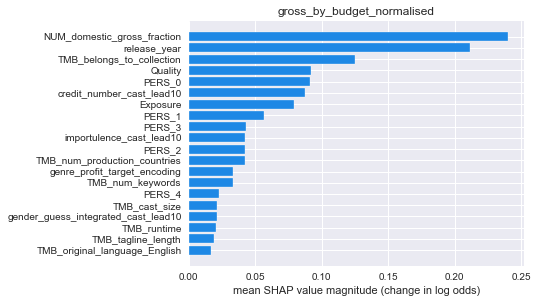

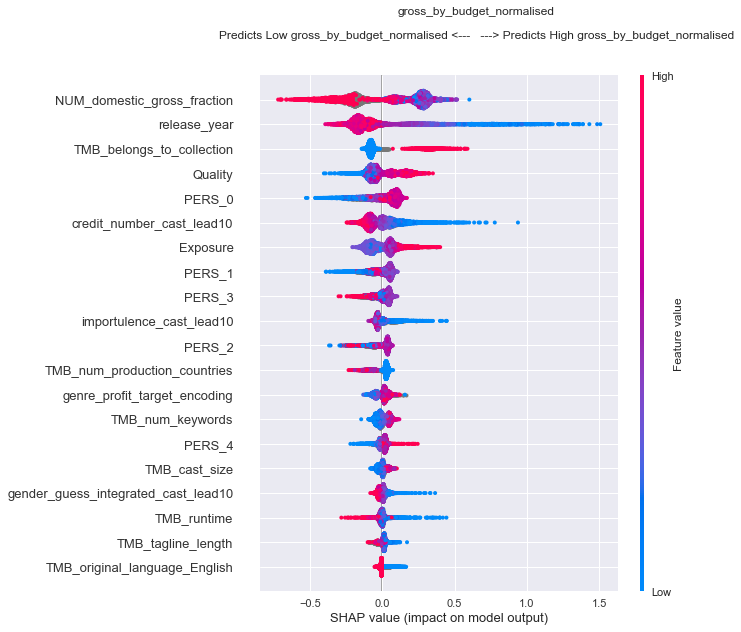

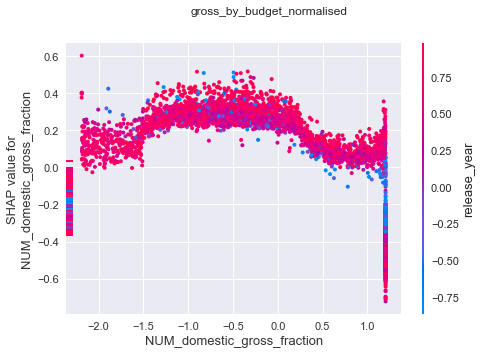

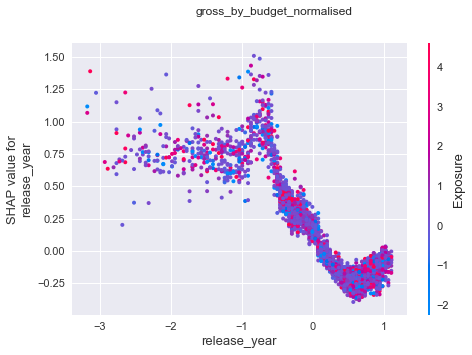

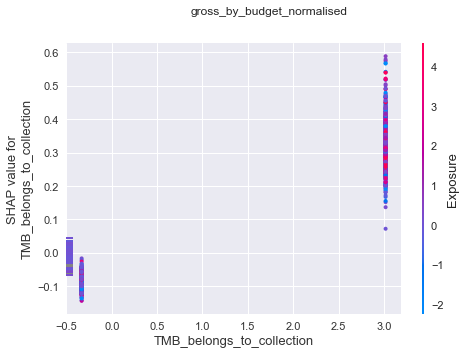

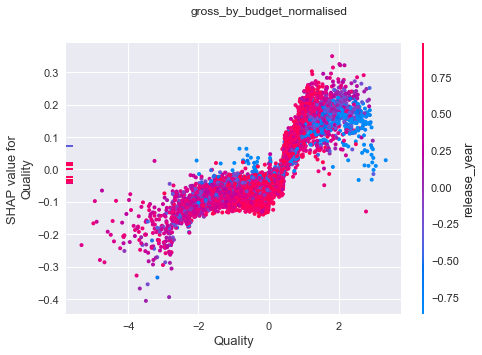

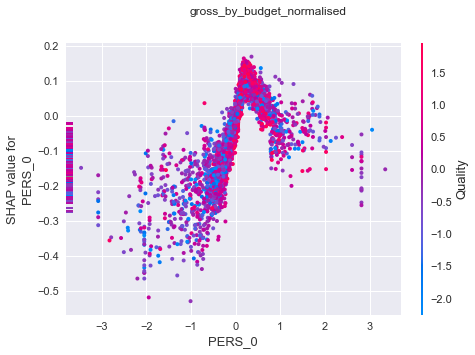

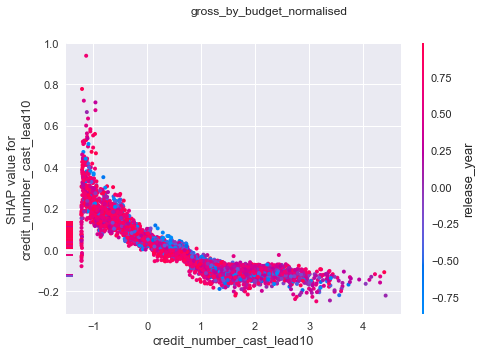

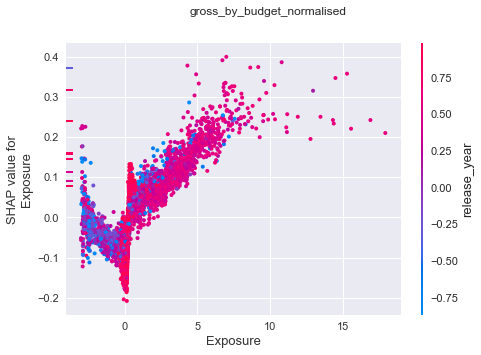

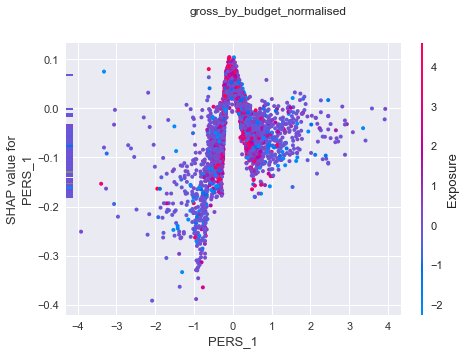

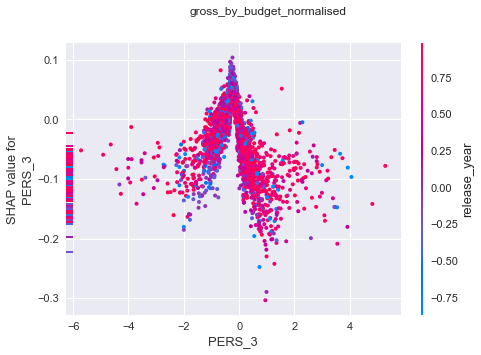

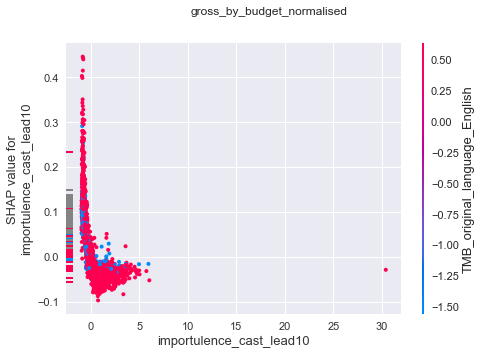

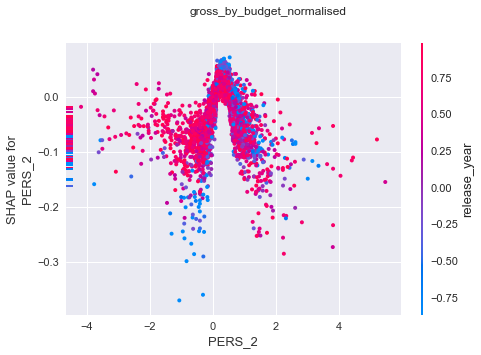

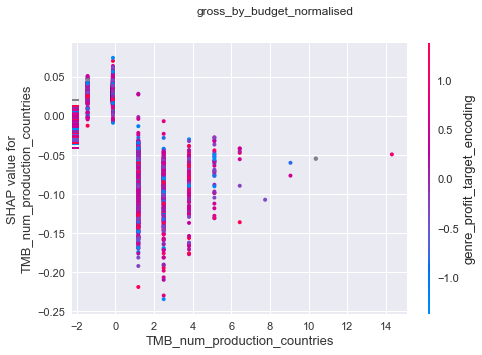

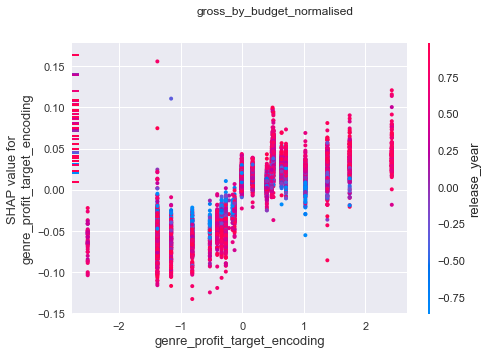

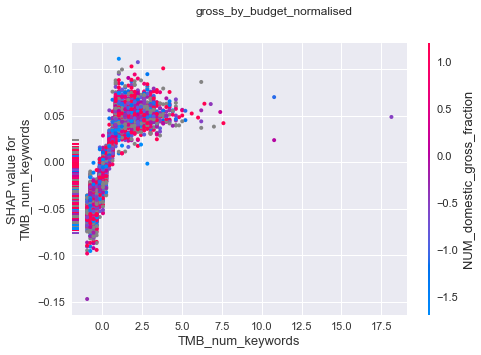

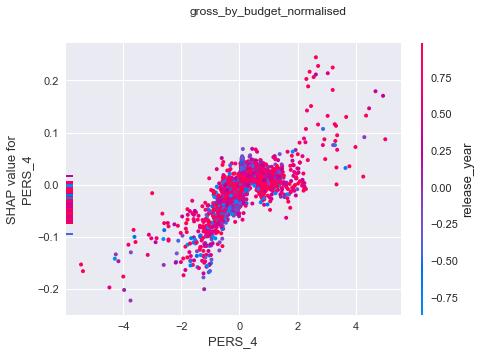

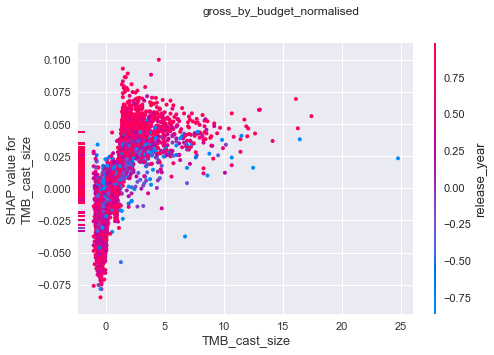

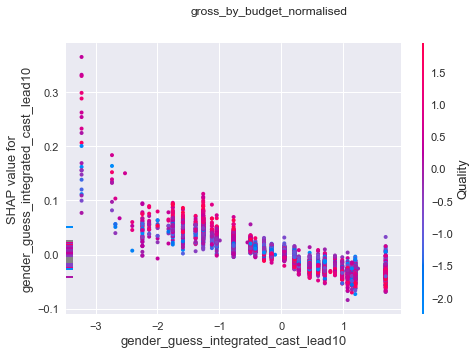

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


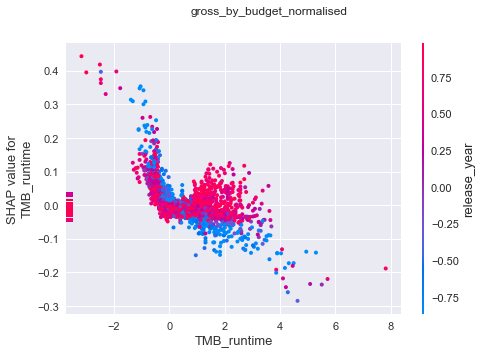

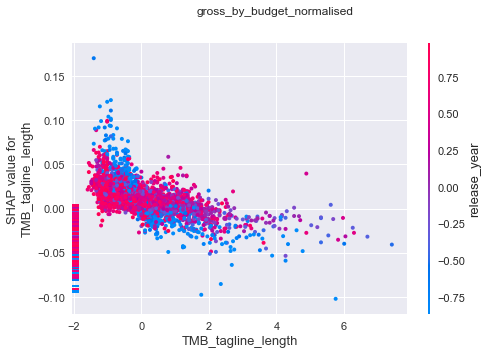

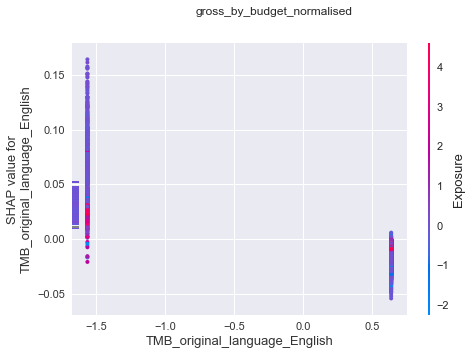

Wall time: 10min 13s


In [358]:
%%time
global BES_output_folder, var_list
drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

# drop_cols.extend()

# drop_cols.extend(["release_year","gross_normalised",
#                   "TMB_num_other_movies_with_same_homepage"]) # inflation is cheating!
drop_cols = ["gross_normalised","budget_normalised"]
var_name = "gross_by_budget_normalised"


BES_output_folder= ".."+os.sep+"Output"+os.sep


df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,20),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True,
                                       output_folder=BES_output_folder,Treatment=Treatment)


In [228]:
INT_df[HETREC_genre_vars.index].sum()
# drop HETREC_genres_Short

HETREC_genres_Adventure      1002.0
HETREC_genres_Animation       279.0
HETREC_genres_Children        519.0
HETREC_genres_Comedy         3566.0
HETREC_genres_Fantasy         534.0
HETREC_genres_Romance        1644.0
HETREC_genres_Drama          5073.0
HETREC_genres_Action         1445.0
HETREC_genres_Crime          1086.0
HETREC_genres_Thriller       1663.0
HETREC_genres_Horror          978.0
HETREC_genres_Mystery         497.0
HETREC_genres_Sci-Fi          740.0
HETREC_genres_IMAX             25.0
HETREC_genres_Documentary     430.0
HETREC_genres_War             494.0
HETREC_genres_Musical         421.0
HETREC_genres_Film-Noir       145.0
HETREC_genres_Western         260.0
HETREC_genres_Short             1.0
dtype: float64

In [262]:
ML_genre_vars

ML_genres_Adventure      58019
ML_genres_Animation      58019
ML_genres_Children       58019
ML_genres_Comedy         58019
ML_genres_Fantasy        58019
ML_genres_Romance        58019
ML_genres_Drama          58019
ML_genres_Action         58019
ML_genres_Crime          58019
ML_genres_Thriller       58019
ML_genres_Horror         58019
ML_genres_Mystery        58019
ML_genres_Sci-Fi         58019
ML_genres_IMAX           58019
ML_genres_Documentary    58019
ML_genres_War            58019
ML_genres_Musical        58019
ML_genres_Western        58019
ML_genres_Film-Noir      58019
dtype: int64

In [196]:
SER_genre_vars

SER_genres_Adventure      45797
SER_genres_Animation      45797
SER_genres_Children       45797
SER_genres_Comedy         45797
SER_genres_Fantasy        45797
SER_genres_Romance        45797
SER_genres_Drama          45797
SER_genres_Action         45797
SER_genres_Crime          45797
SER_genres_Thriller       45797
SER_genres_Horror         45797
SER_genres_Mystery        45797
SER_genres_Sci-Fi         45797
SER_genres_IMAX           45797
SER_genres_Documentary    45797
SER_genres_War            45797
SER_genres_Musical        45797
SER_genres_Western        45797
SER_genres_Film-Noir      45797
dtype: int64

In [201]:
TMB_genres_vars = search(INT_df,"TMB_genres_[A-Z]")

genre_vars = list(ML_genre_vars.index) +\
                      list(SER_genre_vars.index) +\
                      list(TMB_genres_vars.index) +\
                      list(HETREC_genre_vars.index)
genres_corrs = INT_df[genre_vars ].astype('float').corr()

In [178]:
corrank(genres_corrs) # prints a descending list of correlation pair (Max on top)
# (SER_genres_Sci-Fi, TMB_genres_Science Fiction)

                                                 pairs      corr
941                  (ML_genres_IMAX, SER_genres_IMAX)  0.997461
675          (ML_genres_Thriller, SER_genres_Thriller)  0.995003
810            (ML_genres_Mystery, SER_genres_Mystery)  0.994708
1191           (ML_genres_Western, SER_genres_Western)  0.994439
171          (ML_genres_Children, SER_genres_Children)  0.994230
743              (ML_genres_Horror, SER_genres_Horror)  0.994206
393            (ML_genres_Romance, SER_genres_Romance)  0.993200
606                (ML_genres_Crime, SER_genres_Crime)  0.992633
1005   (ML_genres_Documentary, SER_genres_Documentary)  0.992540
876              (ML_genres_Sci-Fi, SER_genres_Sci-Fi)  0.992015
95         (ML_genres_Animation, SER_genres_Animation)  0.991900
1251       (ML_genres_Film-Noir, SER_genres_Film-Noir)  0.991659
1130           (ML_genres_Musical, SER_genres_Musical)  0.990954
320            (ML_genres_Fantasy, SER_genres_Fantasy)  0.990420
536              (ML_genr

In [333]:
# INT_df[genre_vars ]

In [24]:
scarcity_ordered_genre_vars = INT_df[TMB_genres_vars.index].sum().sort_values().index
no_genre = (INT_df[scarcity_ordered_genre_vars]==0).all(axis=1) | (INT_df[scarcity_ordered_genre_vars].isnull()).all(axis=1)
single_genres = INT_df[scarcity_ordered_genre_vars].idxmax(axis=1)
single_genres[no_genre] = np.nan
single_genres = single_genres.apply(lambda x: x.replace("TMB_genres_","") if pd.notnull(x) else np.nan)
scarcity_ordered_genre_vars = [x.replace("TMB_genres_","") for x in scarcity_ordered_genre_vars]

In [ ]:
### make area chart
data = 

# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)
 
# Make the plot
plt.stackplot(range(1,6),  data_perc["group_A"],  data_perc["group_B"],  data_perc["group_C"], labels=['A','B','C'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('100 % stacked area chart')
plt.show()


In [69]:
INT_df["single_genres"] = single_genres

In [176]:
# df = INT_df.groupby(["single_genres","release_year"])["movieId"].count().reset_index().set_index("release_year")

In [67]:
df = INT_df[list(TMB_genres_vars.index)+["release_year"]].dropna().astype('int').set_index("release_year")
df.columns = [x.replace("TMB_genres_","") for x in df.columns]
df = df.groupby("release_year").sum().sort_index()
df = df.apply(lambda x: 100*x/df.sum(axis=1))

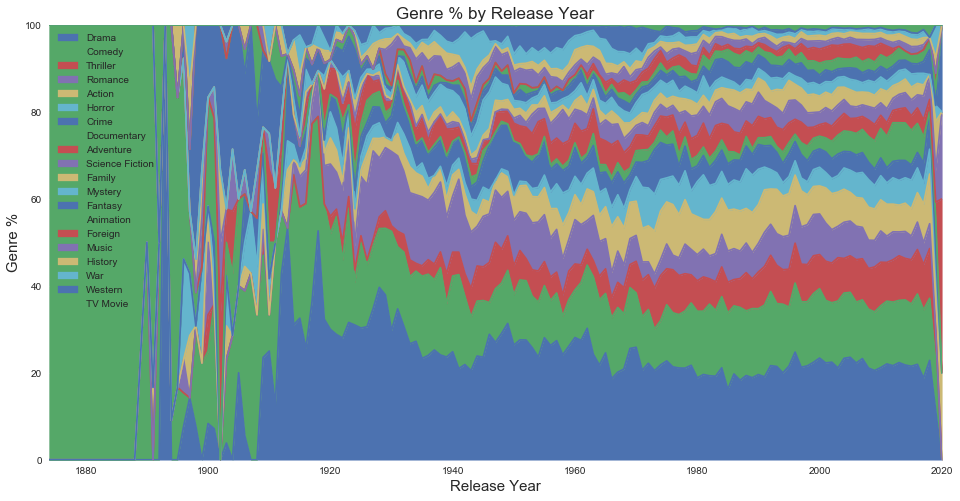

In [91]:
plt.figure(figsize=(16,8));
plt.style.use('seaborn')
df[scarcity_ordered_genre_vars[::-1]].plot.area(ax = plt.gca())
plt.xlabel('Release Year', fontsize=15)
plt.ylabel('Genre %', fontsize=15)
plt.title('Genre % by Release Year',fontsize=17)
plt.ylim([0,100])

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend( [handles[labels.index(x)] for x in scarcity_ordered_genre_vars[::-1]],  [labels[labels.index(x)] for x in scarcity_ordered_genre_vars[::-1]])
plt.show()

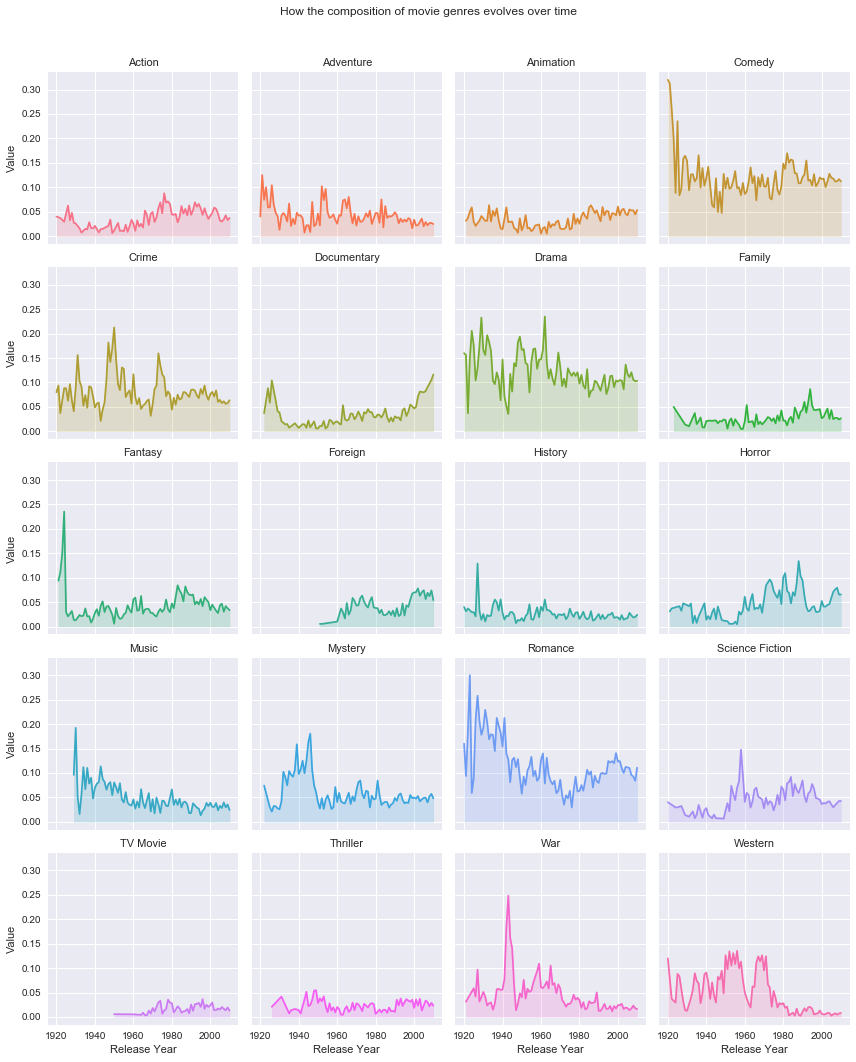

In [133]:
mask = (INT_df["release_year"]>=1920) & (INT_df["release_year"]<=2010)

df = INT_df[mask].groupby(["single_genres","release_year"])["movieId"].count().reset_index().dropna()
df["release_year"] = df["release_year"].astype('int')
year_sums = df.groupby("release_year").sum()
df = df.set_index("release_year")
df["movieId"] = df["movieId"]/year_sums.loc[df.index,"movieId"]

df = df.reset_index()
df.columns = ["Release Year","Genre","Value"]


# Create a grid : initialize it
g = sns.FacetGrid(df, col='Genre', hue='Genre', col_wrap=4, )
 
# Add the line over the area with the plot function
g = g.map(plt.plot, "Release Year", 'Value')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, "Release Year", 'Value', alpha=0.2).set_titles("{col_name} genre")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('How the composition of movie genres evolves over time')
 
plt.show()


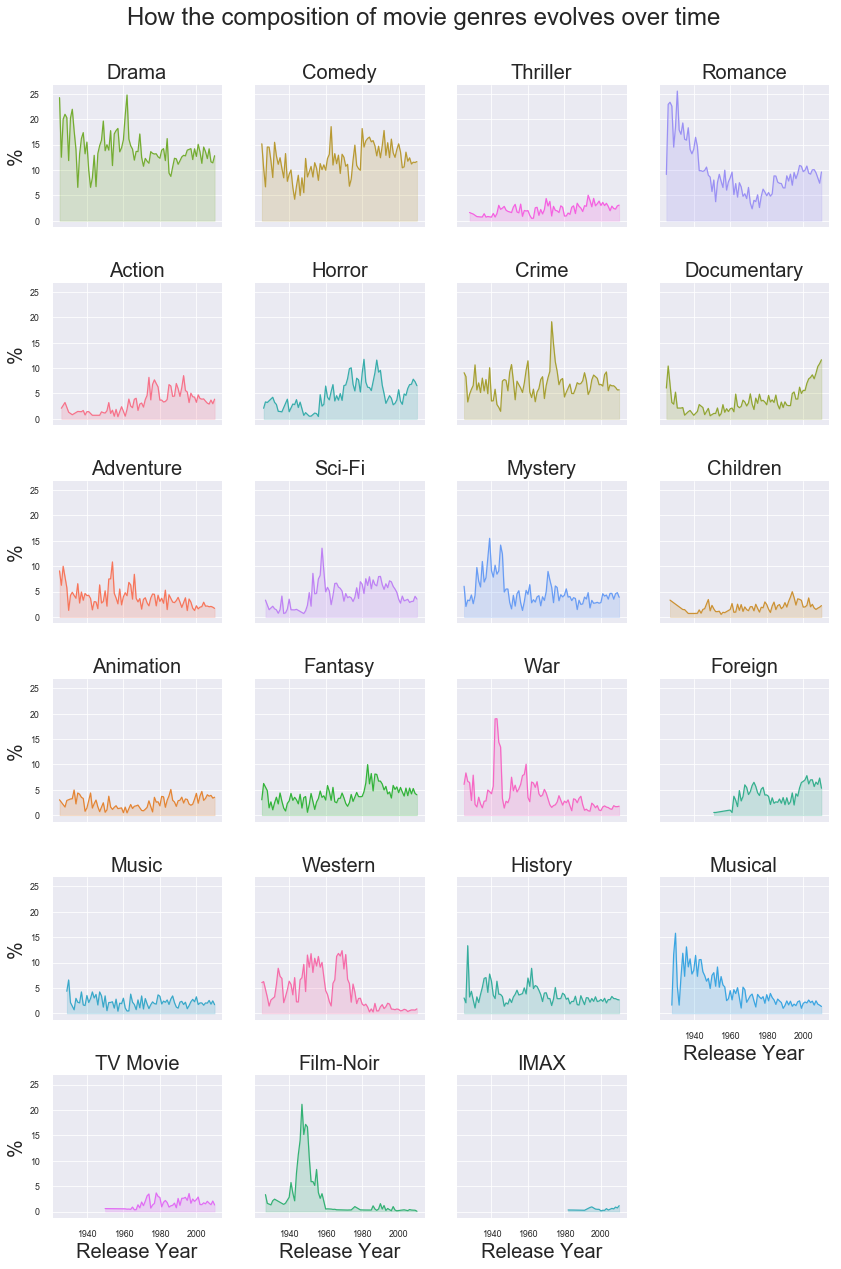

In [373]:
## same but with fully integrated genres
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":20})

int_genres = search(INT_df,"genre__",case_sensitive=True).index

scarcity_ordered_genre_vars = INT_df[int_genres].sum().sort_values().index
no_genre = (INT_df[scarcity_ordered_genre_vars]==0).all(axis=1) | (INT_df[scarcity_ordered_genre_vars].isnull()).all(axis=1)
single_genres = INT_df[scarcity_ordered_genre_vars].astype('float').idxmax(axis=1)
single_genres[no_genre] = np.nan
single_genres = single_genres.apply(lambda x: x.replace("genre__","") if pd.notnull(x) else np.nan)
scarcity_ordered_genre_vars = [x.replace("genre__","") for x in scarcity_ordered_genre_vars]

INT_df["single_genres"]= single_genres

mask = (INT_df["release_year"]>=1925) & (INT_df["release_year"]<=2010)

df = INT_df[mask].groupby(["single_genres","release_year"])["movieId"].count().reset_index().dropna()
df["release_year"] = df["release_year"].astype('int')
year_sums = df.groupby("release_year").sum()
df = df.set_index("release_year")
df["movieId"] = df["movieId"]/year_sums.loc[df.index,"movieId"]

df = df.reset_index()
df.columns = ["Release Year","Genre","%"]
df["%"] = df["%"] * 100


# Create a grid : initialize it
g = sns.FacetGrid(df, col='Genre', hue='Genre', col_wrap=4, col_order =  scarcity_ordered_genre_vars[::-1])
 
# Add the line over the area with the plot function
g = g.map(plt.plot, "Release Year", '%')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, "Release Year", '%', alpha=0.2).set_titles("{col_name} genre")
 
# Control the title of each facet
g = g.set_titles("{col_name}", fontsize=28)
 
# Add a title for the whole plo
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('How the composition of movie genres evolves over time', fontsize=24)
 
plt.show()


In [386]:
INT_df[list(int_genres)+["release_year"]].groupby("release_year")["release_year"].count()

release_year
1874.0       1
1878.0       1
1883.0       1
1887.0       1
1888.0       2
1890.0       5
1891.0       6
1892.0       3
1893.0       1
1894.0      13
1895.0       7
1896.0      14
1897.0       8
1898.0      13
1899.0       5
1900.0      14
1901.0      10
1902.0       2
1903.0      18
1904.0       8
1905.0       5
1906.0       7
1907.0       7
1908.0       6
1909.0      10
1910.0       7
1911.0       6
1912.0      14
1913.0      13
1914.0      19
          ... 
1991.0     421
1992.0     450
1993.0     485
1994.0     533
1995.0     585
1996.0     618
1997.0     648
1998.0     726
1999.0     735
2000.0     811
2001.0     852
2002.0     912
2003.0     917
2004.0    1033
2005.0    1167
2006.0    1339
2007.0    1389
2008.0    1541
2009.0    1581
2010.0    1524
2011.0    1653
2012.0    1732
2013.0    1877
2014.0    1965
2015.0    1952
2016.0    1600
2017.0     608
2018.0     115
2019.0      14
2020.0       2
Name: release_year, Length: 136, dtype: int64

In [389]:
INT_df[list(int_genres)+["release_year"]].apply(lambda x: x.count())

genre__Adventure      58659
genre__Animation      58659
genre__Children       58659
genre__Comedy         58659
genre__Fantasy        58659
genre__Romance        58659
genre__Drama          58659
genre__Action         58659
genre__Crime          58659
genre__Thriller       58659
genre__Horror         58659
genre__Mystery        58659
genre__Sci-Fi         58659
genre__IMAX           58639
genre__Documentary    58659
genre__War            58659
genre__Musical        58639
genre__Western        58659
genre__Film-Noir      58639
genre__History        45354
genre__Music          45354
genre__Foreign        45354
genre__TV Movie       45354
release_year          49415
dtype: int64

In [394]:
INT_df[INT_df["release_year"].isnull()].head(5).dropna(axis=1)

movieId  TMB_movieId  TMB_adult  TMB_belongs_to_collection  \
movieId                                                               
752          752        752.0        0.0                        0.0   
69565      69565      69565.0        0.0                        0.0   
74319      74319      74319.0        0.0                        0.0   
90617      90617      90617.0        0.0                        0.0   
92747      92747      92747.0        0.0                        0.0   

         TMB_original_language                     TMB_original_title  \
movieId                                                                 
752                        0.0                  Vermont Is for Lovers   
69565                      0.0                   Bling: A Planet Rock   
74319                      0.0  Dead Ahead: The Exxon Valdez Disaster   
90617                     16.0                             Pajęczarki   
92747                     13.0                    Pölynimurikauppiaat   

         TMB_popularity TMB_production_companies TMB_production_countries  \
movieId                                                                     
752            0.750000                       []                       []   
69565          0.000000                       []                       []   
74319          0.035294                       []                       []   
90617          0.000000                       []                       []   
92747          0.000000                       []                       []   

        TMB_spoken_languages  ... genre__Documentary genre__War  \
movieId                       ...                                 
752                       []  ...                1.0        0.0   
69565                    [0]  ...                1.0        0.0   
74319                     []  ...                0.0        0.0   
90617                     []  ...                0.0        0.0   
92747                     []  ...                1.0        0.0   

         genre__Musical  genre__Western  genre__Film-Noir  genre__History  \
movieId                                                                     
752                 0.0             0.0               0.0             0.0   
69565               0.0             0.0               0.0             0.0   
74319               0.0             0.0               0.0             0.0   
90617               0.0             0.0               0.0             0.0   
92747               0.0             0.0               0.0             0.0   

         genre__Music  genre__Foreign  genre__TV Movie  \
movieId                                                  
752               0.0             0.0              0.0   
69565             0.0             0.0              0.0   
74319             0.0             0.0              0.0   
90617             0.0             0.0              0.0   
92747             0.0             0.0              0.0   

         genre_profit_target_encoding  
movieId                                
752                         -0.086443  
69565                       -0.086443  
74319                       -0.245325  
90617                        0.007602  
92747                       -0.086443  

[5 rows x 104 columns]

In [ ]:
###########################################################################################################################

In [ ]:
# int_genres, single_genres





In [84]:
INT_df["release_decade"] = release_decade

In [79]:
search(INT_df,"decade")

TMB_release_decade    45271
dtype: int64

In [70]:
search(INT_df,"gender").index

gender_guess_integrated_crew_mean      43936
gender_guess_integrated_cast_mean      42457
gender_guess_integrated_crew_lead      42589
gender_guess_integrated_cast_lead      35494
gender_guess_integrated_crew_lead5     43898
gender_guess_integrated_cast_lead10    42432
dtype: int64

In [97]:
var_list = list(int_genres) + ["single_genres"] + list(search(INT_df,"gender").index) + ["TMB_runtime"] + ["release_year"] + ["release_decade"]
output_df = INT_df[var_list].copy()
output_df.columns = [x.replace("gender_guess_integrated","male_fraction").replace("TMB_runtime","runtime") for x in output_df.columns]

In [98]:
output_df.to_csv(Dataset_directory+"Processed"+os.sep+"sample_output"+".csv")

In [94]:
output_df.columns

Index(['genre__Adventure', 'genre__Animation', 'genre__Children',
       'genre__Comedy', 'genre__Fantasy', 'genre__Romance', 'genre__Drama',
       'genre__Action', 'genre__Crime', 'genre__Thriller', 'genre__Horror',
       'genre__Mystery', 'genre__Sci-Fi', 'genre__IMAX', 'genre__Documentary',
       'genre__War', 'genre__Musical', 'genre__Western', 'genre__Film-Noir',
       'genre__History', 'genre__Music', 'genre__Foreign', 'genre__TV Movie',
       'single_genres', 'male_fraction_crew_mean', 'male_fraction_cast_mean',
       'male_fraction_crew_lead', 'male_fraction_cast_lead',
       'male_fraction_crew_lead5', 'male_fraction_cast_lead10', 'TMB_runtime',
       'release_year', 'release_decade'],
      dtype='object')

In [298]:
# check out all the release data variables

In [299]:
# release_date.value_counts()

In [300]:
# INT_df[['TMB_release_day','SER_release_day','NUM_release_day']].mode()

In [301]:
# INT_df[['TMB_release_month','SER_release_month','NUM_release_month']].mode()

In [302]:


# 1969-12-31 ???? dodgy! UNIX start date!
    # -> chase this back, figure out which data column this is from!
    
# XXXX-01-01 -> the year is fine, day/month is not!

day_and_month_not_actually_given = (release_date.dt.day==1) & (release_date.dt.month==1)
release_date[~day_and_month_not_actually_given].value_counts().head(10) # fine other than the UNIX date!


2015-01-23    32
2013-09-06    30
2010-10-01    30
2012-10-12    30
2012-10-05    29
2011-09-23    29
2014-10-17    28
2013-10-11    28
2014-09-19    27
2014-09-05    27
Name: NUM_date, dtype: int64

In [81]:
release_decade = INT_df["release_year"].apply(lambda x: str(int(10*np.floor(x/10))) if pd.notnull(x) else np.nan)
release_decade_dummies = pd.get_dummies(release_decade , prefix = "release_decade__")

In [304]:
import calendar
from datetime import date
release_month = INT_df['release_month'].apply(lambda x: calendar.month_abbr[int(x)] if pd.notnull(x) else np.nan)
release_month[day_and_month_not_actually_given] = np.nan
release_month_dummies = pd.get_dummies(release_month , prefix = "release_month__")
release_month.value_counts()

Oct    4860
Sep    4380
Dec    3882
Nov    3877
Apr    3871
Mar    3871
Aug    3449
Jun    3406
May    3399
Feb    3178
Jan    3019
Jul    2839
Name: release_month, dtype: int64

In [305]:
# day in month
release_day = INT_df['release_day'].copy()#.apply(lambda x: calendar.month_abbr[int(x)] if pd.notnull(x) else np.nan)
release_day.loc[day_and_month_not_actually_given] = np.nan
release_day_dummies = pd.get_dummies(release_day , prefix = "release_day_of_the_month__")
# release_day_dummies.columns = release_day_dummies.columns.astype('int')
release_day.value_counts()

1.0     2784
25.0    1558
15.0    1549
10.0    1511
11.0    1495
6.0     1488
20.0    1470
22.0    1464
18.0    1456
12.0    1447
9.0     1446
13.0    1443
19.0    1428
14.0    1428
17.0    1410
24.0    1380
21.0    1380
16.0    1380
26.0    1372
23.0    1365
5.0     1352
7.0     1322
8.0     1311
27.0    1297
28.0    1288
4.0     1286
2.0     1249
3.0     1227
30.0    1186
29.0    1168
31.0     920
Name: release_day, dtype: int64

In [306]:
release_weekday = release_date.apply(lambda x: calendar.day_name[x.weekday()] if pd.notnull(x) else np.nan)
release_weekday.loc[day_and_month_not_actually_given] = np.nan
release_weekday_dummies = pd.get_dummies(release_weekday , prefix = "release_weekday__")
release_weekday.value_counts()

Friday       17288
Wednesday     6245
Thursday      5795
Saturday      4557
Tuesday       4084
Sunday        3207
Monday        2855
Name: NUM_date, dtype: int64

In [307]:
movies_by_year = INT_df.groupby("release_year")["movieId"].count()
INT_df["num_other_releases_that_year"] = INT_df["release_year"].apply(lambda x: movies_by_year[x]-1 if pd.notnull(x) else np.nan)

In [308]:
INT_df[release_weekday_dummies.columns]=release_weekday_dummies
INT_df[release_day_dummies.columns]    = release_day_dummies
INT_df[release_month_dummies.columns]  = release_month_dummies
INT_df[release_decade_dummies.columns] = release_decade_dummies

In [309]:
INT_df_ord_only[release_weekday_dummies.columns]=release_weekday_dummies
INT_df_ord_only[release_day_dummies.columns]    = release_day_dummies
INT_df_ord_only[release_month_dummies.columns]  = release_month_dummies
INT_df_ord_only[release_decade_dummies.columns] = release_decade_dummies
INT_df_ord_only["num_other_releases_that_year"] = INT_df["release_year"].apply(lambda x: movies_by_year[x]-1 if pd.notnull(x) else np.nan)

In [336]:
### Collections

# do mostly seem to be about sequences of movies (not, say, abstract themes with different movies/all the work of one director/big set of "classic movies")


TMB_collections = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_collections"+".csv",index_col="Unnamed: 0")
TMB_collections.index = TMB_collections["id"]
INT_df["TMB_collection_size"]          = INT_df["TMB_collectionId"].apply(lambda x: TMB_collections.loc[int(x),"collection_size"] if pd.notnull(x) else np.nan)
INT_df_ord_only["TMB_collection_size"] = INT_df["TMB_collectionId"].apply(lambda x: TMB_collections.loc[int(x),"collection_size"] if pd.notnull(x) else np.nan)

In [338]:
search(INT_df,"_title$")

TMB_original_title                              45354
TMB_title                                       45354
TMB_original_title_differs_from_title           45354
TMB_title_used_by_num_other_movies              45354
TMB_production_companies_Working Title Films    33527
HETREC_title                                    10194
HETREC_spanishTitle                             10194
SER_title                                       49093
ML_title                                        58019
NUM_title                                        5249
dtype: int64

In [342]:
title_vars = ["TMB_original_title","TMB_title","TMB_original_title_differs_from_title",
              "TMB_title_used_by_num_other_movies","HETREC_title","HETREC_spanishTitle",
              "SER_title","ML_title","NUM_title"]

title_vars = ["TMB_title","HETREC_title","SER_title","ML_title","NUM_title"]

In [351]:
titles = INT_df[title_vars].copy()
titles["SER_title"] = titles["SER_title"].apply(lambda x: x.split("(")[0] if pd.notnull(x) else np.nan)
titles["ML_title"] = titles["ML_title"].apply(lambda x: x.split("(")[0] if pd.notnull(x) else np.nan)
titles = titles.applymap(lambda x: x.strip().lower() if pd.notnull(x) else np.nan)

In [372]:
num_different_titles = titles.apply(lambda x: len(np.unique(x.dropna())) ,axis=1)

In [373]:
num_different_titles.value_counts()

1    48794
2     9311
3      739
0      466
4       14
dtype: int64

In [386]:
release_decade.value_counts()

2010    14708
2000    11851
1990     5909
1980     4178
1970     3802
1960     2801
1950     2212
1940     1645
1930     1453
1920      452
1910      198
1900      110
1890       85
1880        6
2020        3
1870        2
Name: release_year, dtype: int64

In [381]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

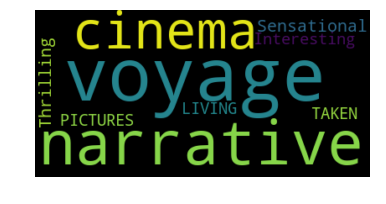

In [388]:
# 1900s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="1900"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

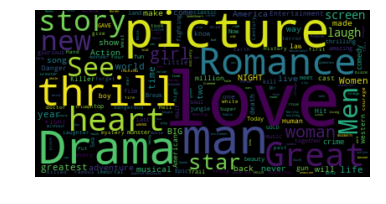

In [391]:
# 1930s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="1930"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

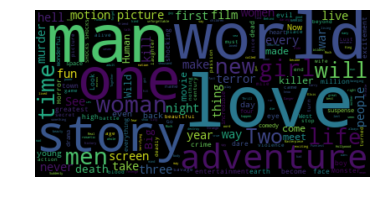

In [390]:
# 1960s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="1960"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

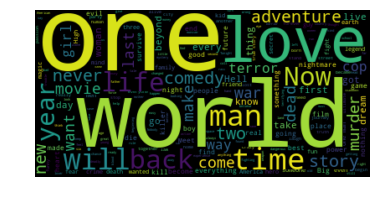

In [392]:
# 1980s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="1980"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

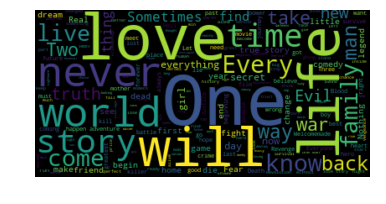

In [389]:
# 2010s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="2010"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:26:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.09759
Will train until validation_0-rmse hasn't improved in 11.100000000000001 rounds.
[1]	validation_0-rmse:1.07396
[2]	validation_0-rmse:1.05141
[3]	validation_0-rmse:1.03092
[4]	validation_0-rmse:1.01221
[5]	validation_0-rmse:0.9931
[6]	validation_0-rmse:0.977547
[7]	validation_0-rmse:0.960904
[8]	validation_0-rmse:0.946336
[9]	validation_0-rmse:0.932304
[10]	validation_0-rmse:0.917965
[11]	validation_0-rmse:0.905523
[12]	validation_0-rmse:0.893745
[13]	validation_0-rmse:0.884056
[14]	validation_0-rmse:0.873205
[15]	validation_0-rmse:0.864134
[16]	validation_0-rmse:0.854295
[17]	validation_0-rmse:0.845616
[18]	validation_0-rmse:0.837064
[19]	validation_0-rmse:0.828552
[20]	validation_0-rmse:0.820892
[21]	validation_0-rmse:0.814162
[22]	validation_0-rmse:0.808829
[23]	validation_0-rmse:0.80219
[24]	

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


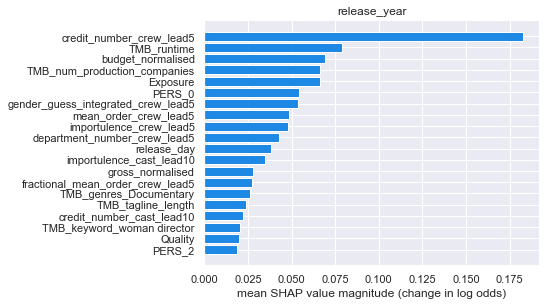

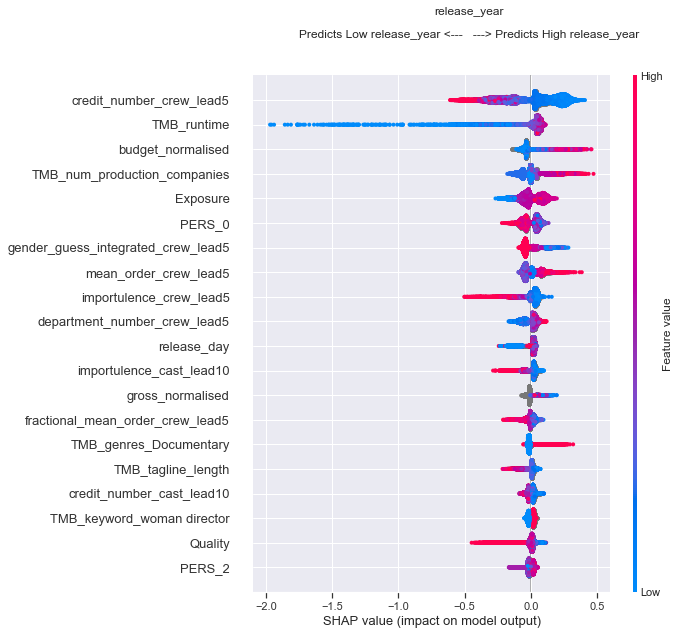

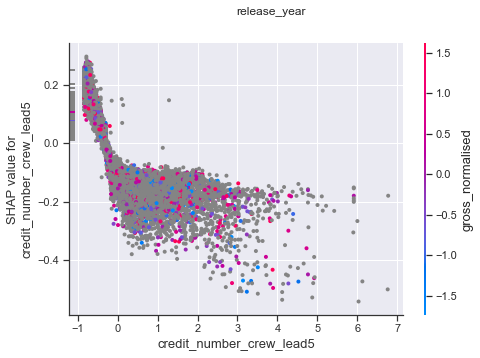

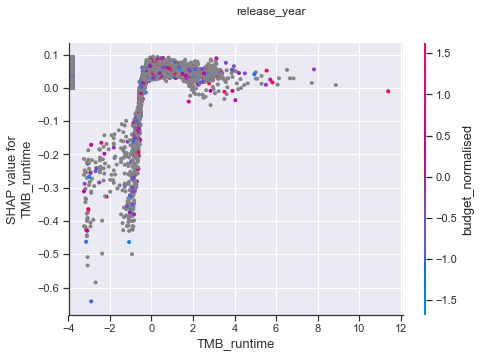

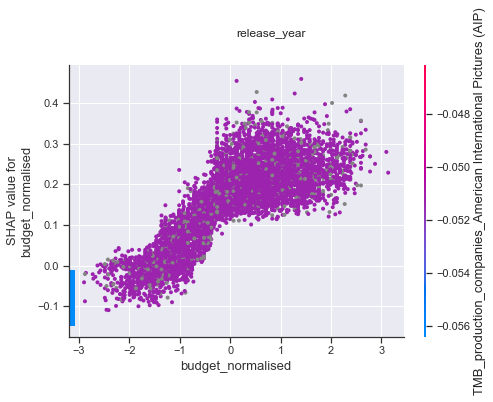

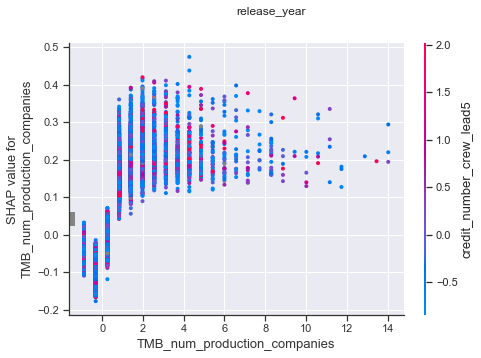

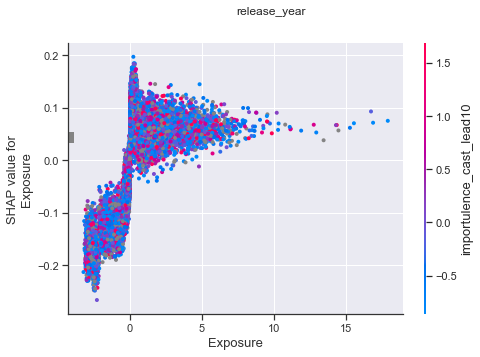

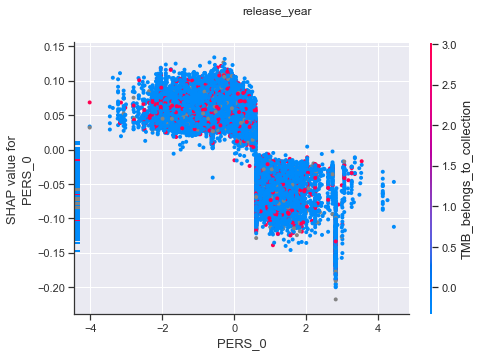

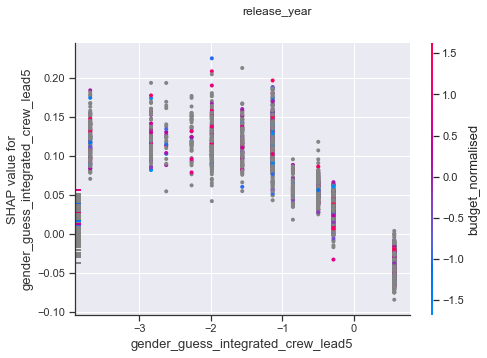

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


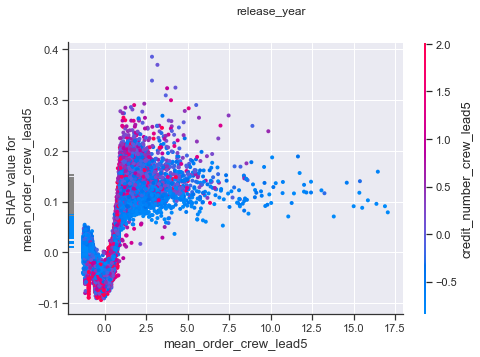

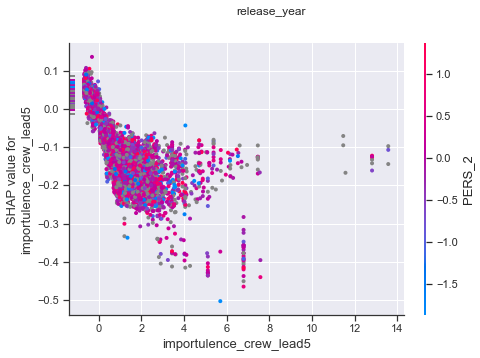

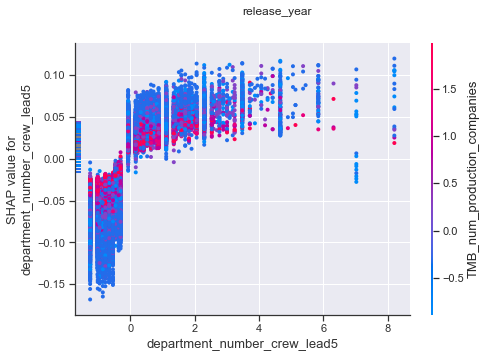

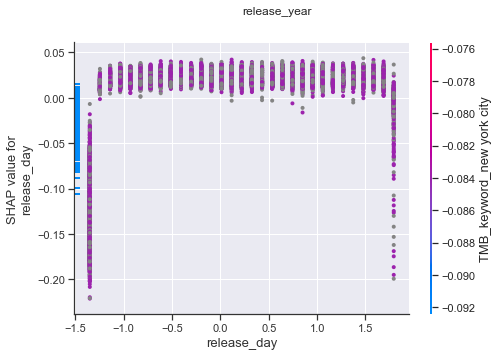

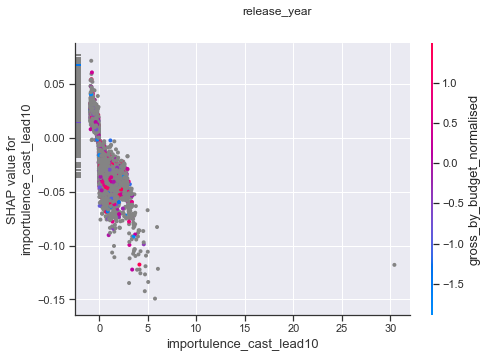

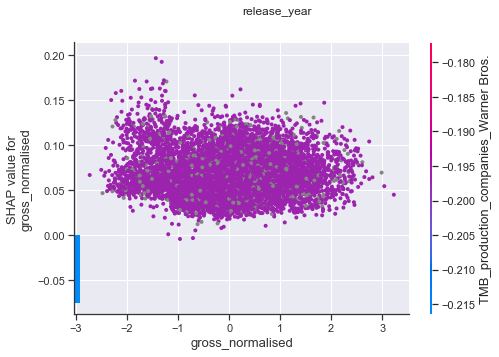

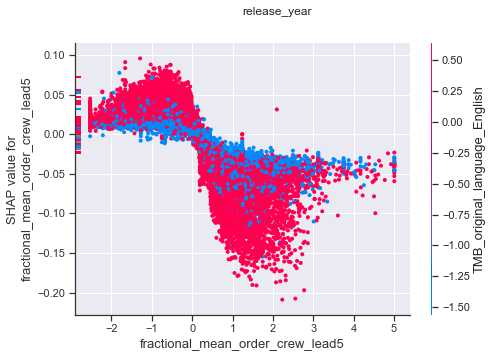

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


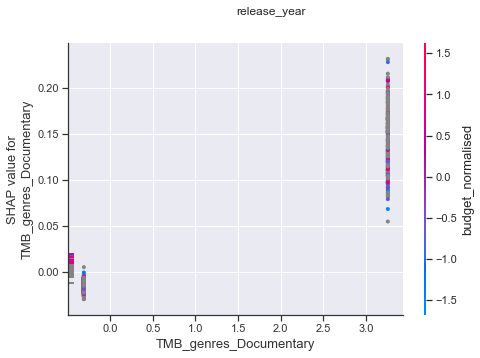

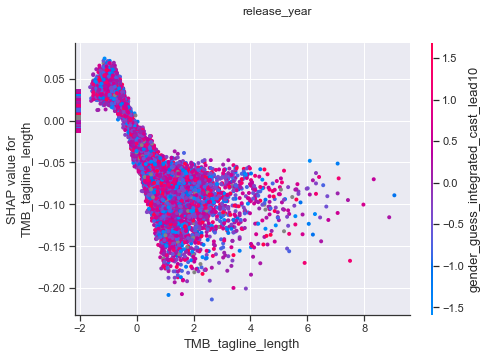

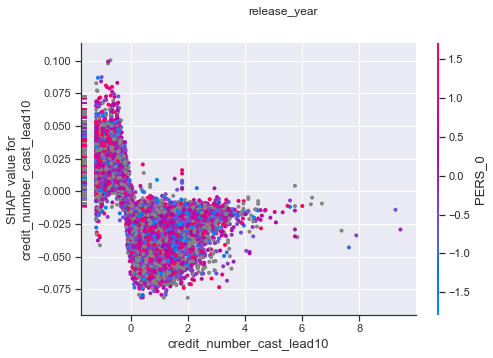

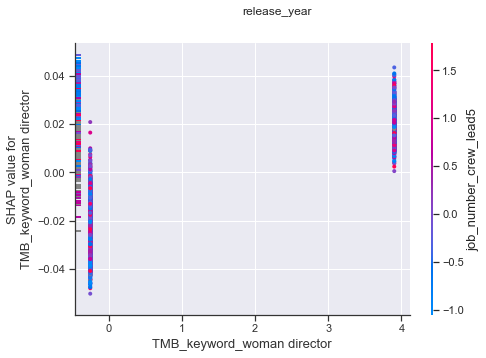

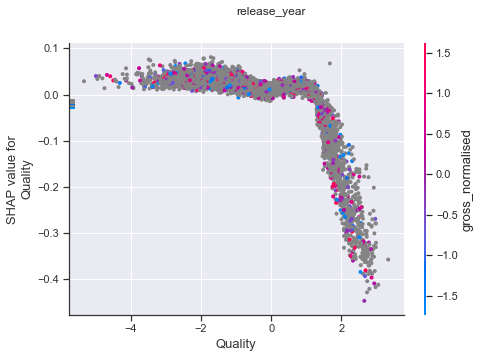

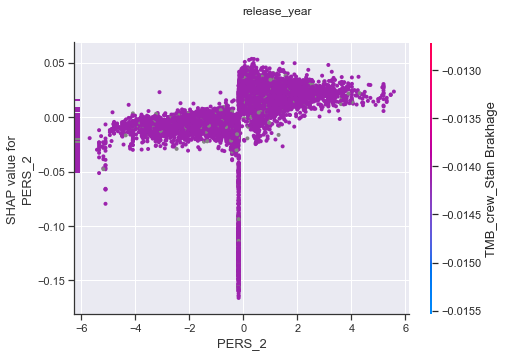

Wall time: 21min 34s


In [310]:
%%time
global BES_output_folder
drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

drop_cols.extend(list(release_decade_dummies.columns))
drop_cols.extend(["num_other_releases_that_year","TMB_num_other_movies_with_same_homepage"])

# drop_cols.extend(["release_year","gross_normalised",
#                   "TMB_num_other_movies_with_same_homepage"]) # inflation is cheating!
var_name = "release_year"


BES_output_folder= ".."+os.sep+"Output"+os.sep


df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,20),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True,
                                       output_folder=BES_output_folder,Treatment=Treatment)


In [352]:
%%time
global BES_output_folder
drop_cols = list(release_decade_dummies.columns)
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

# drop_cols.extend()

# drop_cols.extend(["release_year","gross_normalised",
#                   "TMB_num_other_movies_with_same_homepage"]) # inflation is cheating!
drop_cols = ["gross_normalised","budget_normalised"]
var_name = "gross_by_budget_normalised"


BES_output_folder= ".."+os.sep+"Output"+os.sep


df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,20),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True,
                                       output_folder=BES_output_folder,Treatment=Treatment)


NameError: name 'release_decade_dummies' is not defined

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:58:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.08255
Will train until validation_0-rmse hasn't improved in 10.4 rounds.
[1]	validation_0-rmse:1.05559
[2]	validation_0-rmse:1.03311
[3]	validation_0-rmse:1.00883
[4]	validation_0-rmse:0.986915
[5]	validation_0-rmse:0.968058
[6]	validation_0-rmse:0.949004
[7]	validation_0-rmse:0.931203
[8]	validation_0-rmse:0.915202
[9]	validation_0-rmse:0.900426
[10]	validation_0-rmse:0.887395
[11]	validation_0-rmse:0.875154
[12]	validation_0-rmse:0.863448
[13]	validation_0-rmse:0.8531
[14]	validation_0-rmse:0.843237
[15]	validation_0-rmse:0.834515
[16]	validation_0-rmse:0.826057
[17]	validation_0-rmse:0.818371
[18]	validation_0-rmse:0.810973
[19]	validation_0-rmse:0.805995
[20]	validation_0-rmse:0.799284
[21]	validation_0-rmse:0.794406
[22]	validation_0-rmse:0.789532
[23]	validation_0-rmse:0.784846
[24]	validation_0

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:02:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


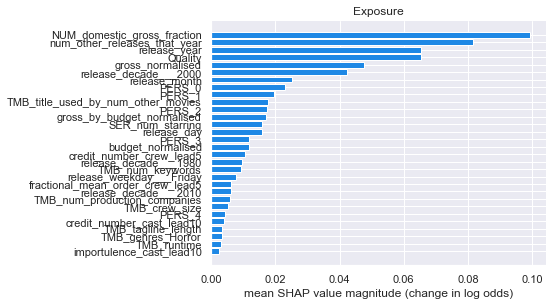

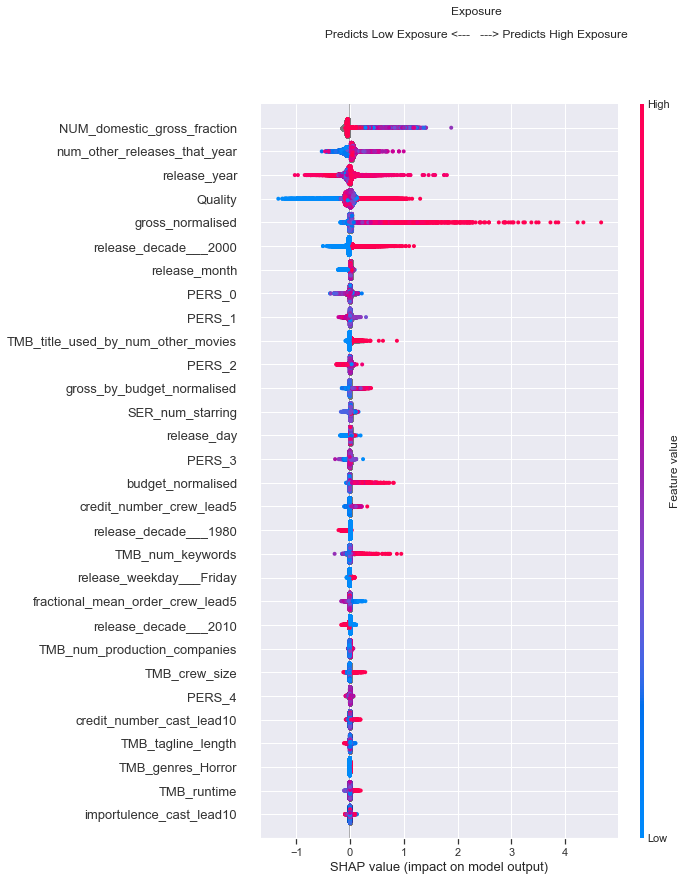

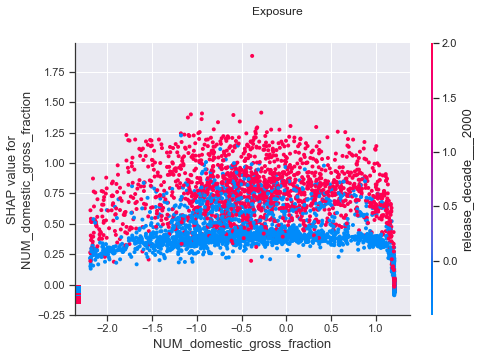

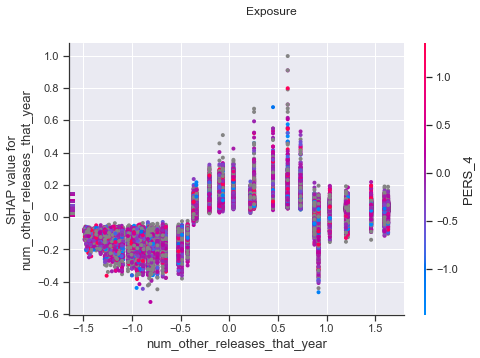

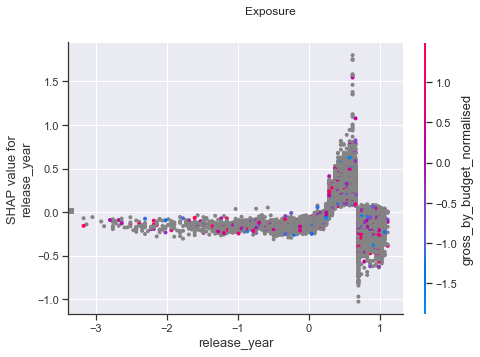

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


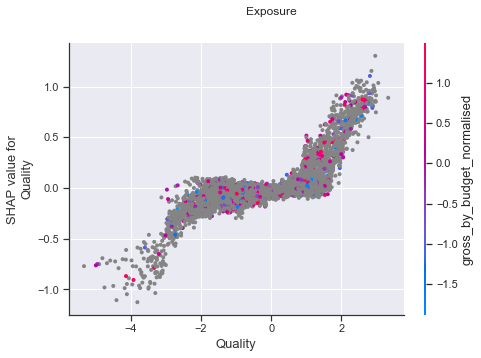

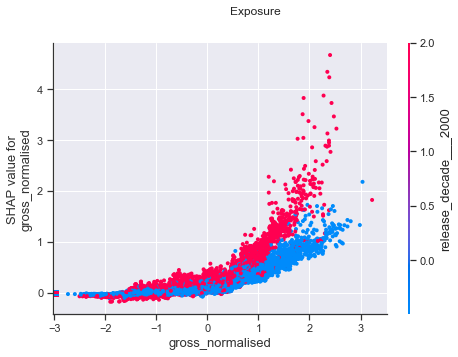

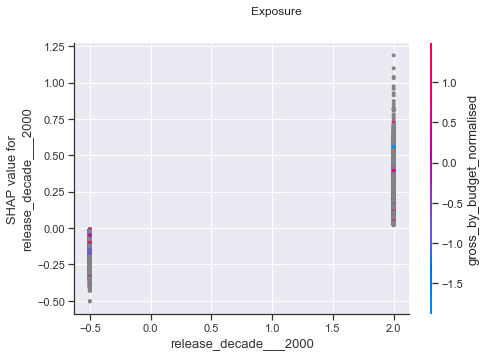

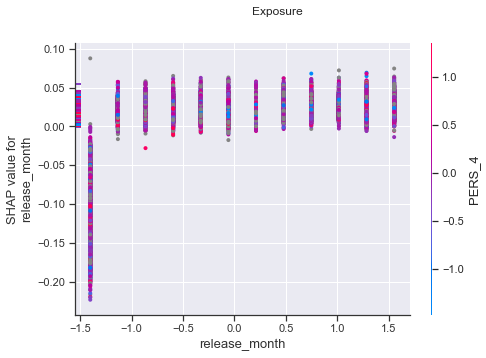

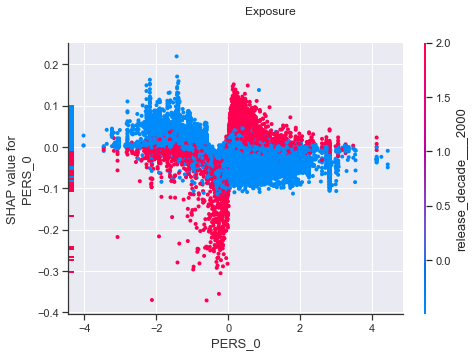

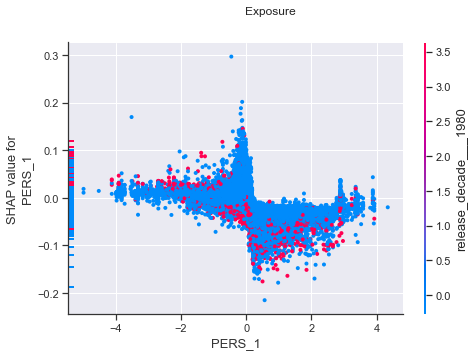

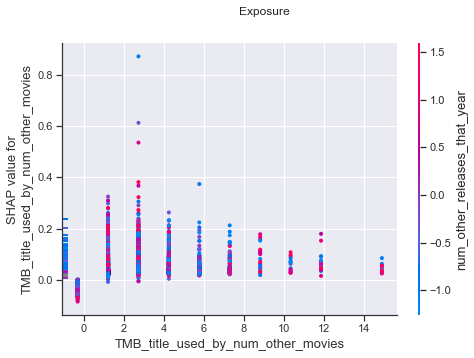

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


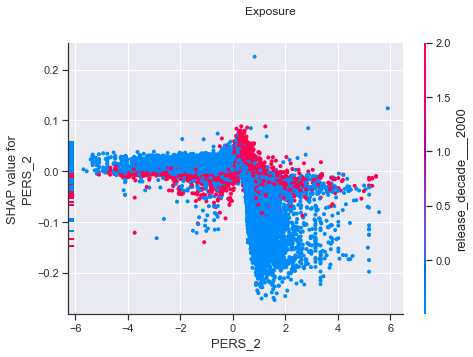

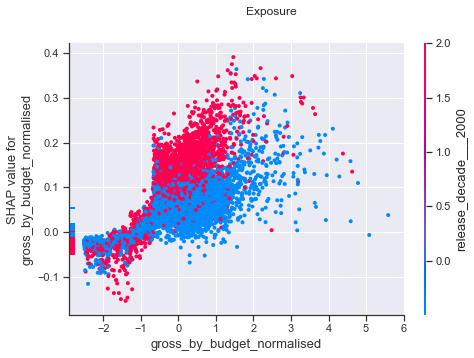

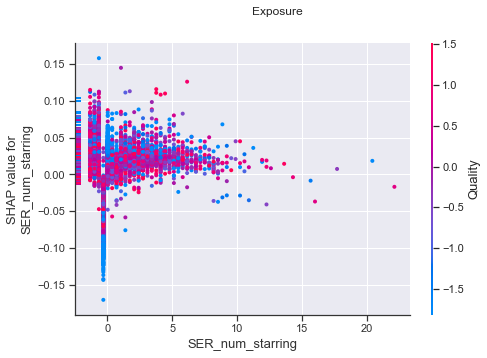

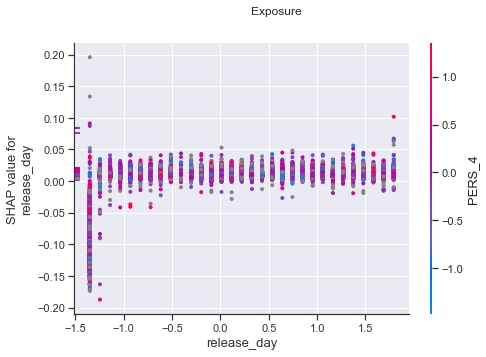

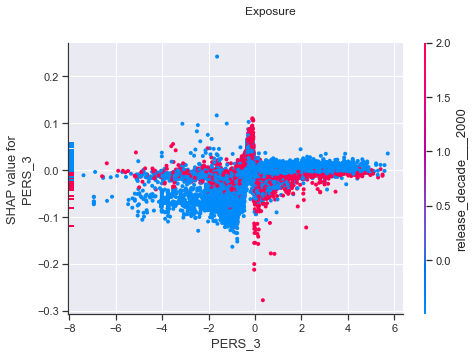

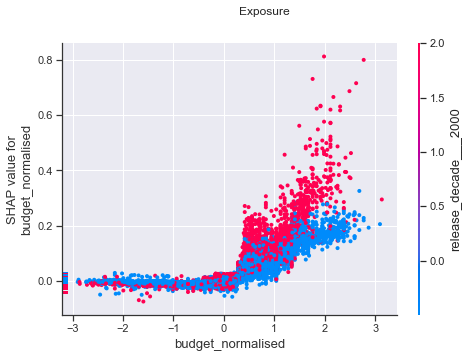

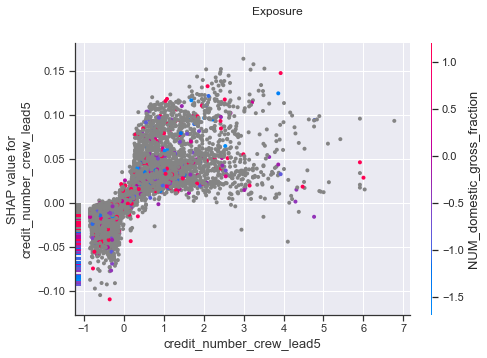

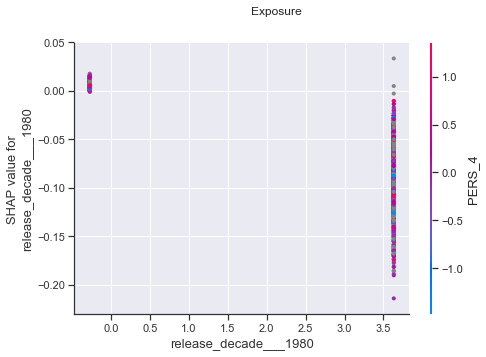

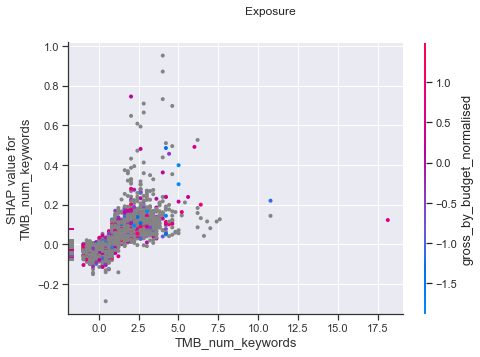

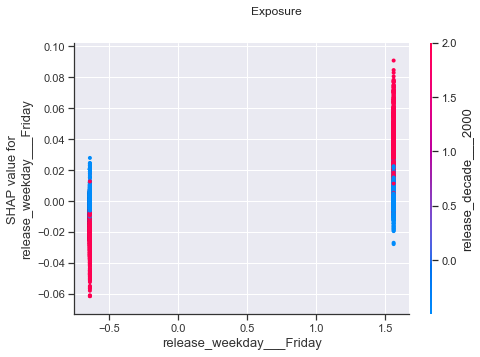

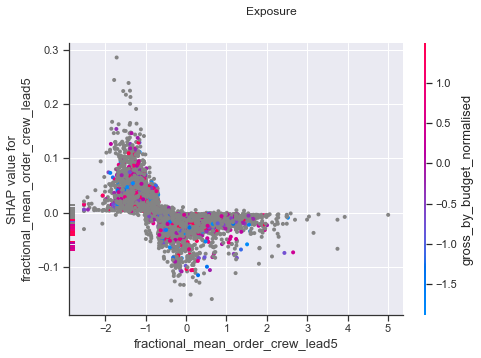

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


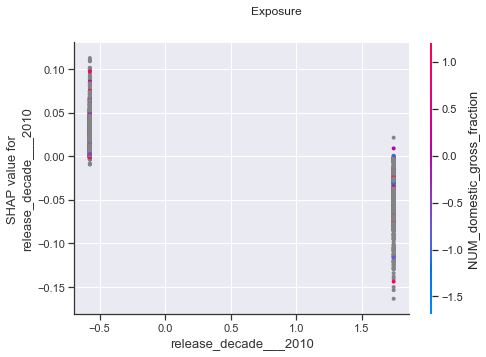

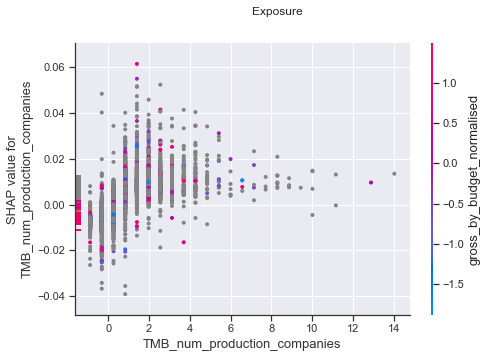

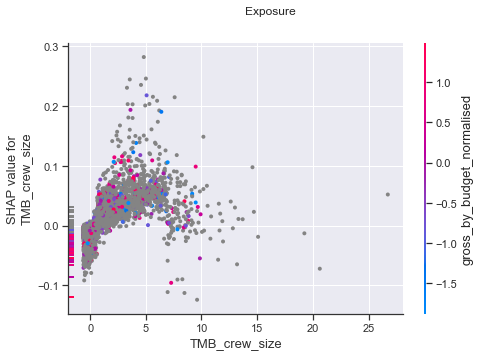

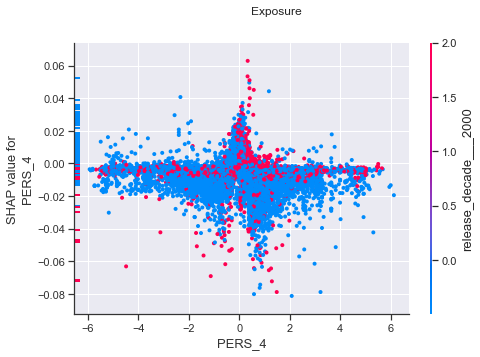

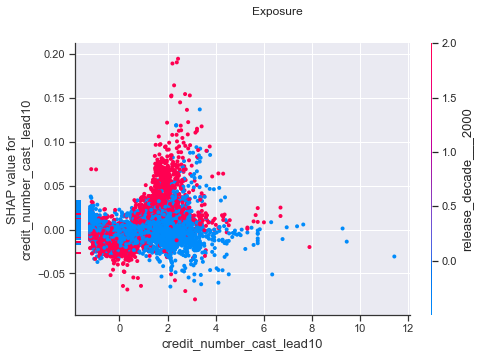

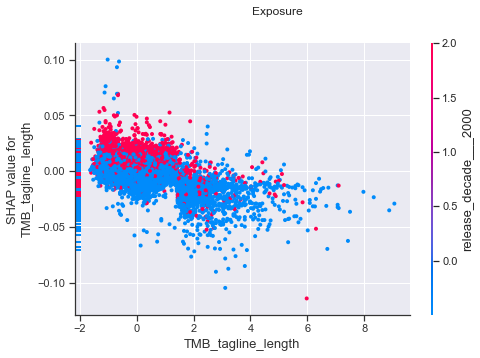

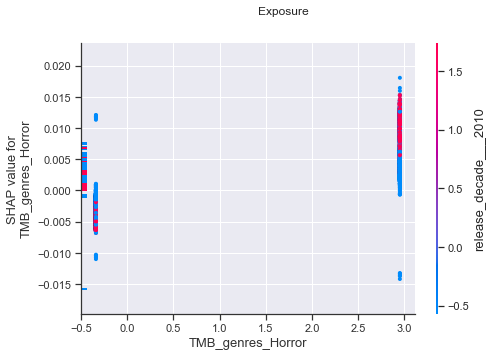

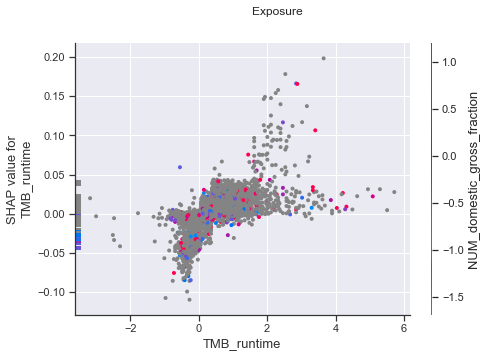

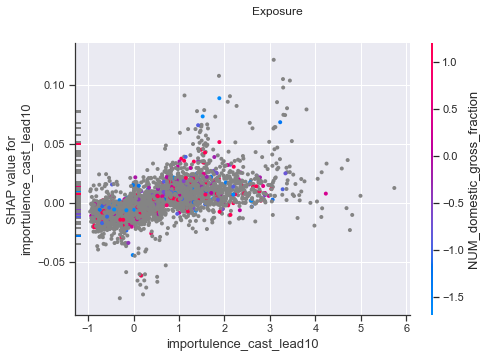

Wall time: 27min 53s


In [317]:
%%time

drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

# drop_cols.extend(fused_cols)

# drop_cols.extend(["tops","flops"])
var_name = "Exposure"


BES_output_folder= ".."+os.sep+"Output"+os.sep

df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )
mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:26:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.10295
Will train until validation_0-rmse hasn't improved in 10.3 rounds.
[1]	validation_0-rmse:1.08513
[2]	validation_0-rmse:1.06775
[3]	validation_0-rmse:1.05155
[4]	validation_0-rmse:1.03702
[5]	validation_0-rmse:1.02442
[6]	validation_0-rmse:1.01218
[7]	validation_0-rmse:1.0009
[8]	validation_0-rmse:0.99078
[9]	validation_0-rmse:0.98129
[10]	validation_0-rmse:0.971712
[11]	validation_0-rmse:0.962942
[12]	validation_0-rmse:0.954737
[13]	validation_0-rmse:0.947451
[14]	validation_0-rmse:0.940721
[15]	validation_0-rmse:0.934458
[16]	validation_0-rmse:0.928456
[17]	validation_0-rmse:0.922645
[18]	validation_0-rmse:0.917586
[19]	validation_0-rmse:0.912514
[20]	validation_0-rmse:0.907904
[21]	validation_0-rmse:0.903617
[22]	validation_0-rmse:0.899809
[23]	validation_0-rmse:0.895712
[24]	validation_0-rmse

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


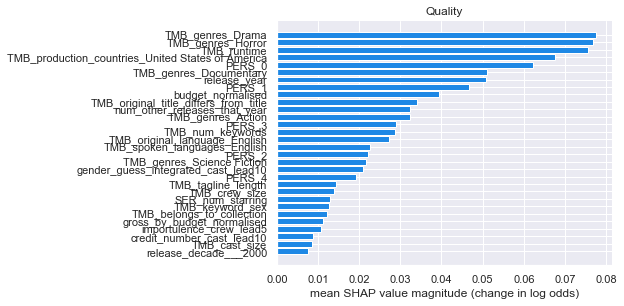

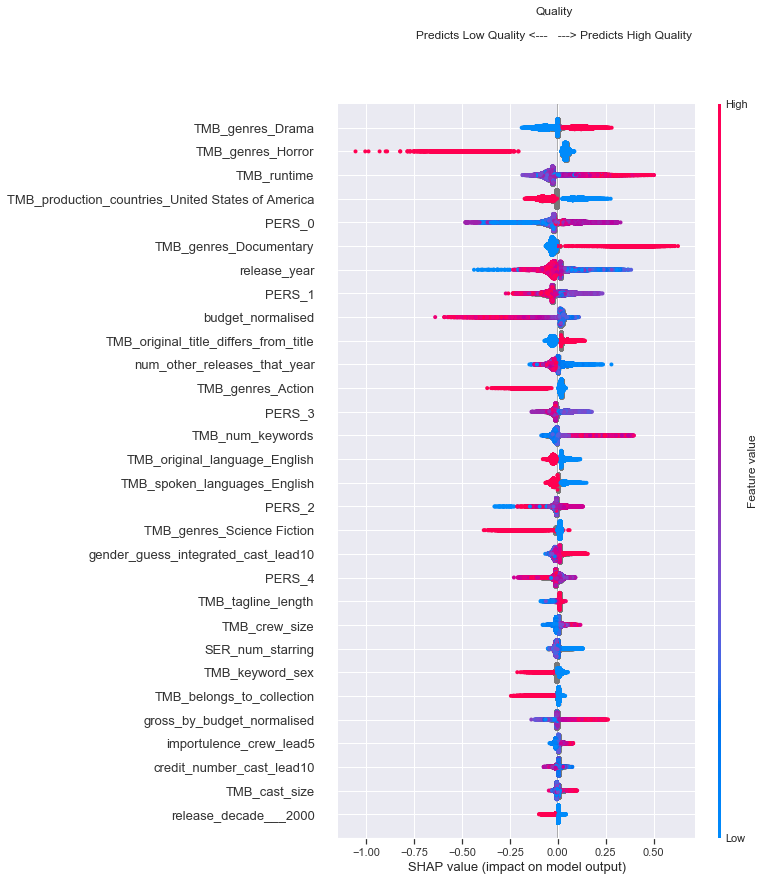

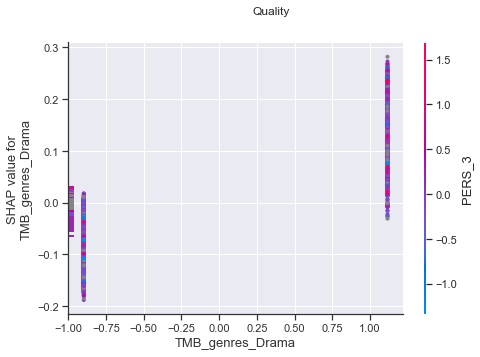

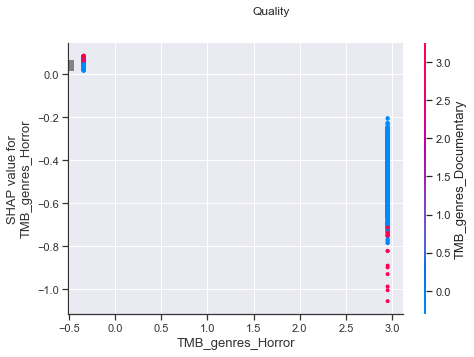

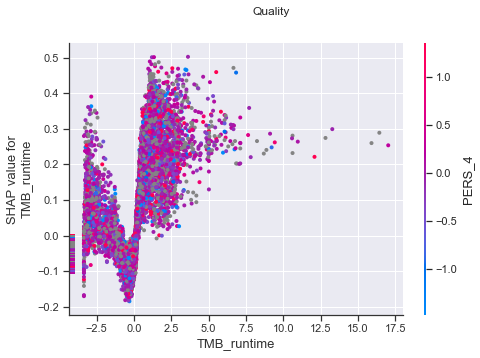

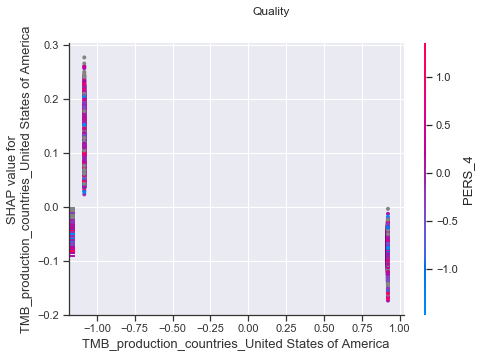

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


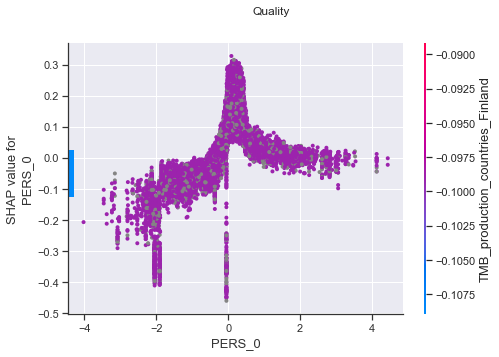

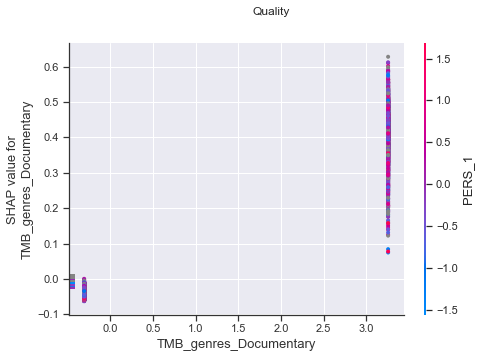

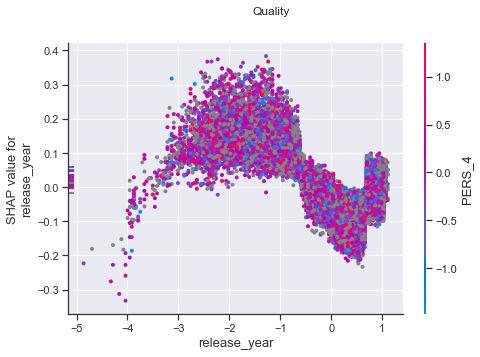

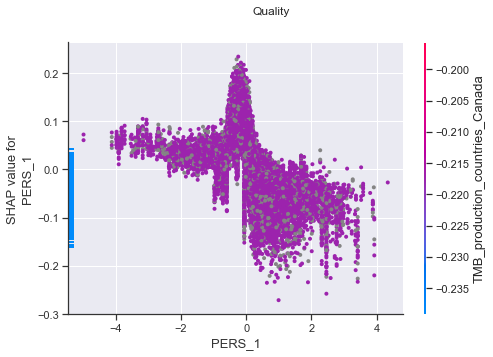

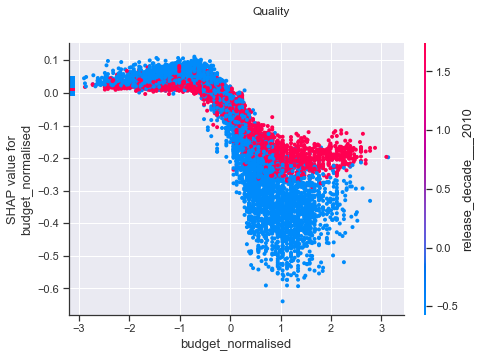

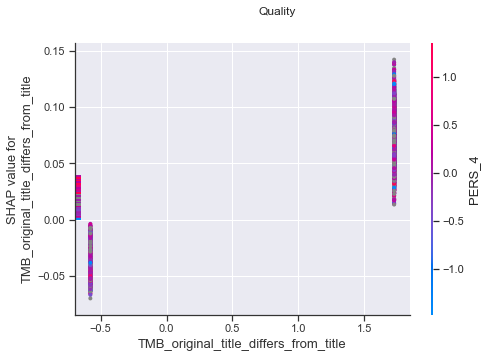

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


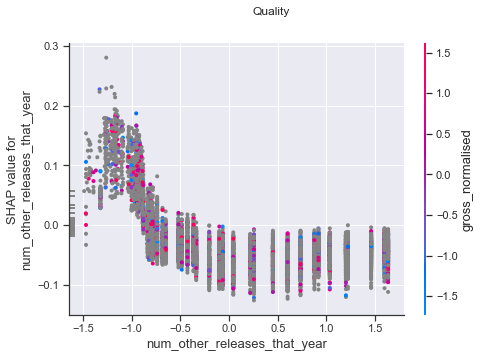

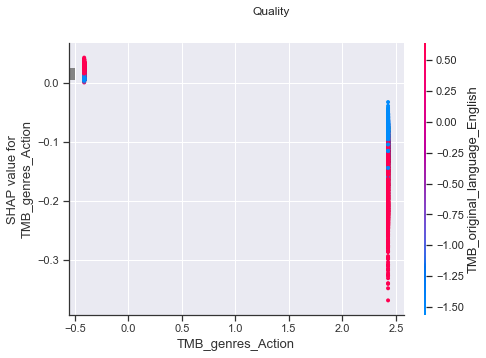

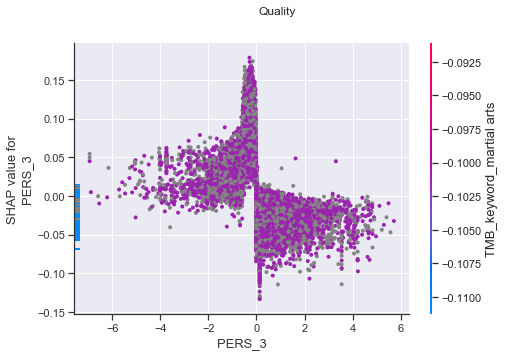

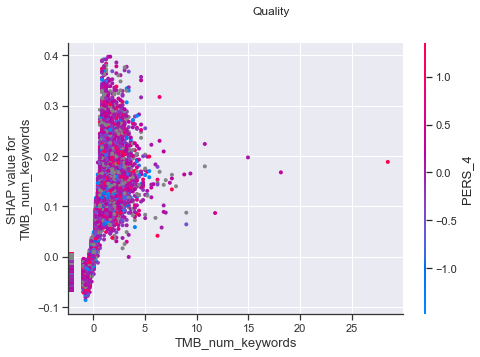

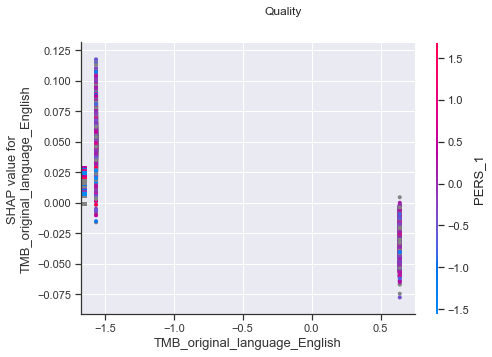

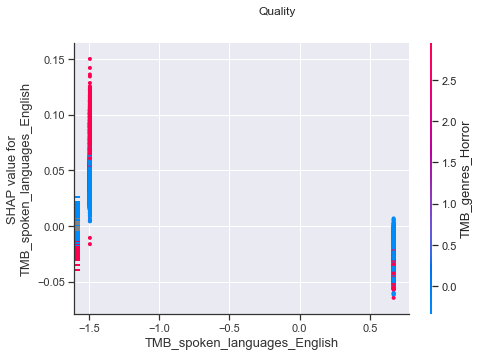

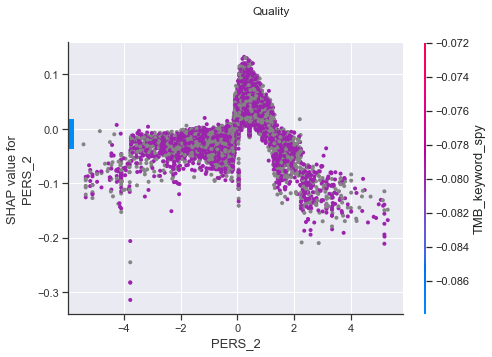

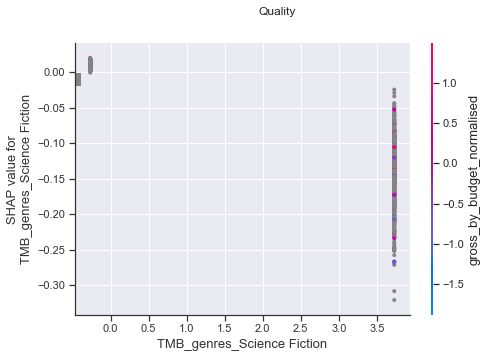

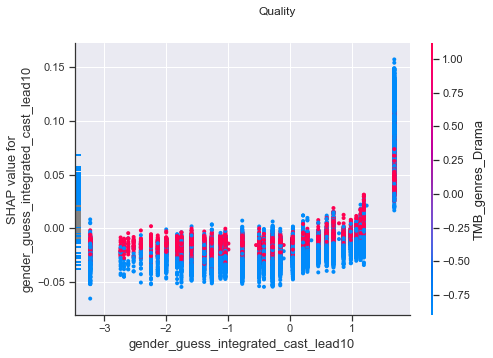

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


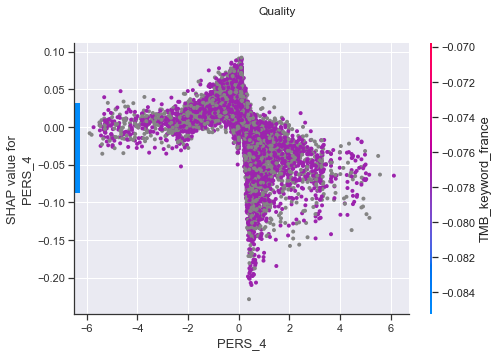

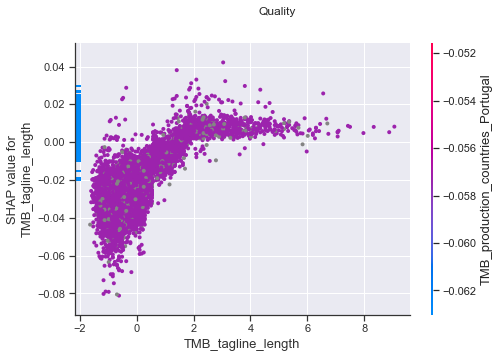

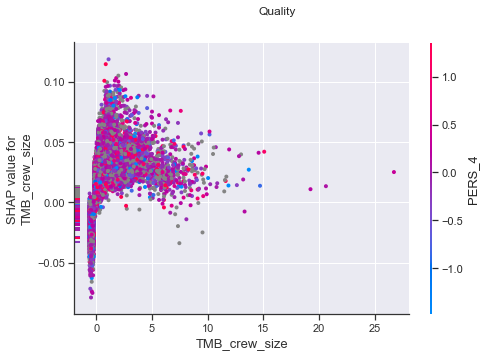

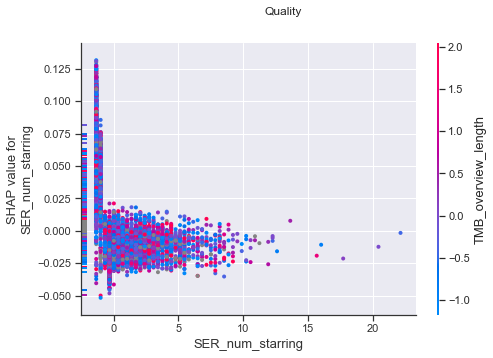

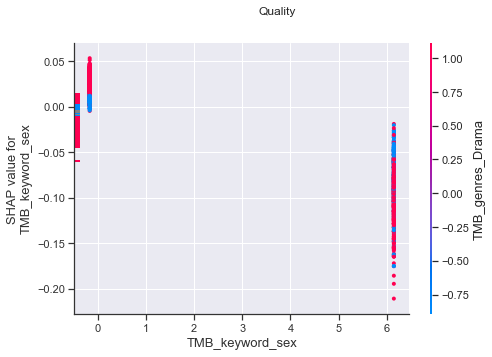

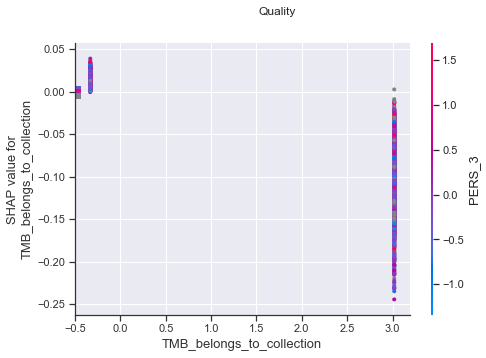

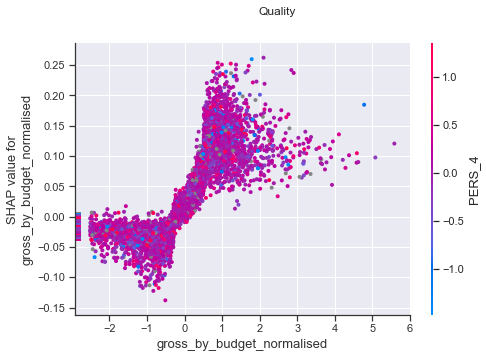

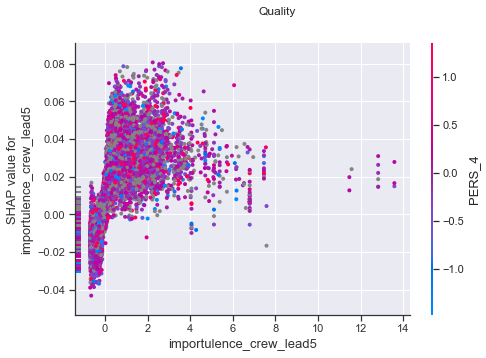

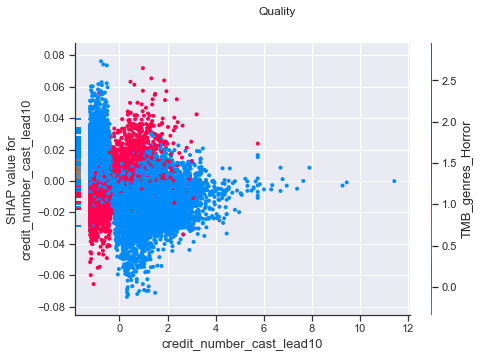

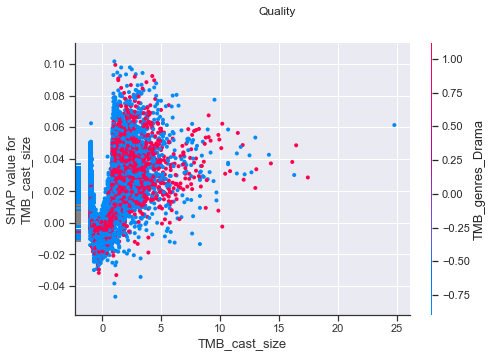

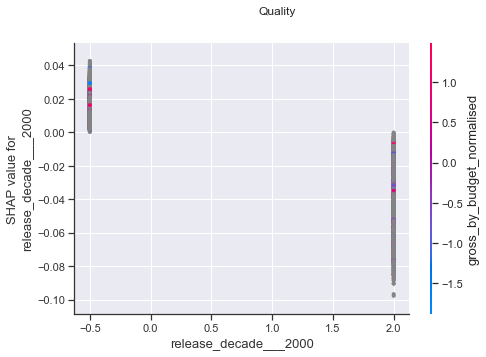

Wall time: 28min 4s


In [318]:
%%time

drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

drop_cols.extend(["Exposure"])

# drop_cols.extend(["tops","flops"])
var_name = "Quality"


BES_output_folder= ".."+os.sep+"Output"+os.sep

df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )
mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)


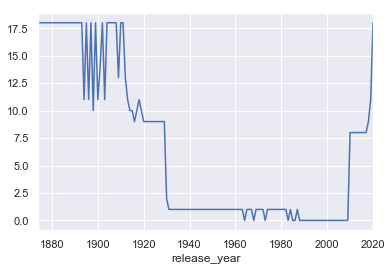

In [7]:
(INT_df.groupby("release_year")[ratings_cols].count()<10).sum(axis=1).plot()
# chop before

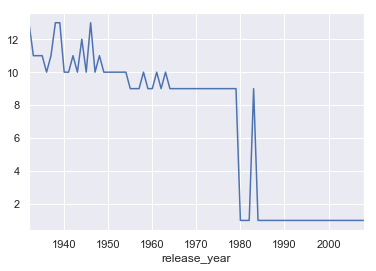

In [9]:
var0 = "release_year"
mask = (INT_df[var0]>1931) & (INT_df[var0]<2009)
(INT_df[mask].groupby("release_year")[ratings_cols].count()<100).sum(axis=1).plot()

In [18]:
from wpca import PCA, WPCA, EMPCA

In [31]:
np.linalg.matrix_rank( BES_std.fillna(BES_std.mean()).values, 1 )

18

In [60]:
ratings_cols = ['HETREC_rtAudienceScore', 'HETREC_rtAudienceNumRatings',
       'HETREC_rtTopCriticsNumReviews', 'HETREC_rtAllCriticsNumReviews',
       'ML_ratings_mean', 'SER_ratings_mean', 'TMB_vote_average_normalised',
       'HETREC_rtAllCriticsScore', 'PERS_ratings_mean', 'HETREC_ratings_mean',
       'TMB_vote_count', 'TMB_popularity_normalised',
       'SER_rating',"HETREC_rtTopCriticsScore",
        'HETREC_ratings_std','SER_ratings_std','PERS_ratings_std','ML_ratings_std']
# ratings_cols.remove("HETREC_rtTopCriticsNumReviews")
# ratings_cols.remove("SER_ratings_mean")
# ratings_cols.remove("SER_ratings_std")
# ratings_cols.remove("HETREC_ratings_mean")
# ratings_cols.remove("PERS_ratings_mean")
# ratings_cols.remove("HETREC_ratings_std")
# ratings_cols.remove("PERS_ratings_std")

# ratings_cols = ['HETREC_rtAudienceScore', 'ML_ratings_mean']

In [41]:
data.notnull().sum().sort_values()

SER_rating                        1666
HETREC_ratings_std                9505
HETREC_rtAudienceScore            9966
HETREC_rtAudienceNumRatings       9966
HETREC_rtAllCriticsNumReviews     9966
HETREC_rtTopCriticsScore          9966
HETREC_rtAllCriticsScore          9966
HETREC_ratings_mean              10106
PERS_ratings_std                 24057
PERS_ratings_mean                35135
SER_ratings_std                  39428
TMB_vote_average_normalised      42460
ML_ratings_std                   43659
TMB_vote_count                   45354
TMB_popularity_normalised        45354
SER_ratings_mean                 49072
ML_ratings_mean                  53810
dtype: int64

In [33]:
%%time
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())

naive_cross_corrs = data.corr()    
pd.set_option('max_colwidth', 80)
corrank(naive_cross_corrs) # prints a descending list of correlation pair (Max on top)

                                                              pairs      corr
33   (HETREC_rtTopCriticsNumReviews, HETREC_rtAllCriticsNumReviews)  0.959386
62                              (ML_ratings_mean, SER_ratings_mean)  0.937841
151                               (SER_ratings_std, ML_ratings_std)  0.893246
66                           (ML_ratings_mean, HETREC_ratings_mean)  0.812526
65                             (ML_ratings_mean, PERS_ratings_mean)  0.739576
108                        (PERS_ratings_mean, HETREC_ratings_mean)  0.729220
77                            (SER_ratings_mean, PERS_ratings_mean)  0.715193
12               (HETREC_rtAudienceScore, HETREC_rtTopCriticsScore)  0.705887
78                          (SER_ratings_mean, HETREC_ratings_mean)  0.680305
89               (TMB_vote_average_normalised, HETREC_ratings_mean)  0.634194
64                      (ML_ratings_mean, HETREC_rtAllCriticsScore)  0.621151
103            (HETREC_rtAllCriticsScore, HETREC_rtTopCriticsSco

In [63]:
INT_df[ratings_cols].notnull().any(axis=1).sum()

55670

In [64]:
INT_df.shape

(59324, 933)

In [67]:
data = INT_df[ratings_cols].copy()
drop_movies = data[data.isnull().all(axis=1)].index
data.drop(drop_movies,inplace=True)


weights = data.notnull().astype('float')

clean_feature_set_std = StandardScaler().fit_transform(data.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = data.columns,
                             index   = data.index      )

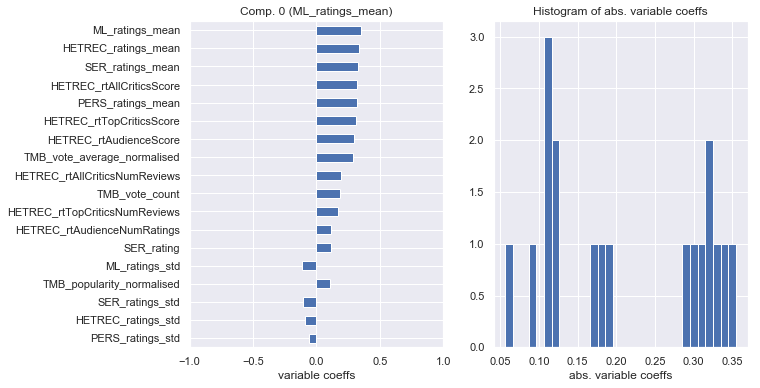

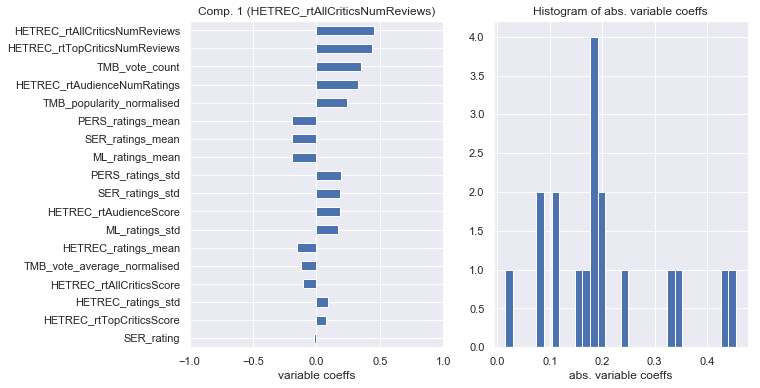

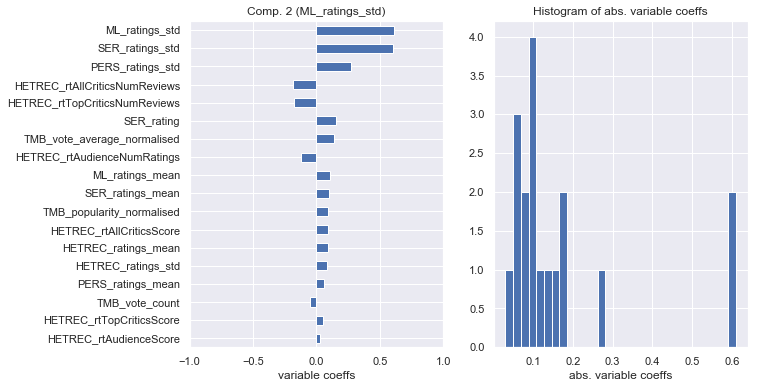

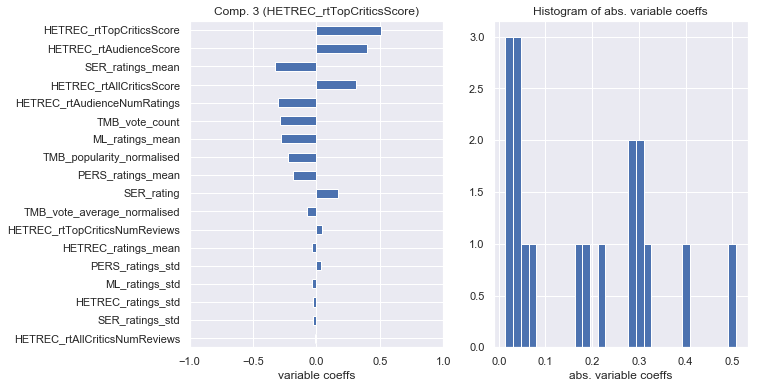

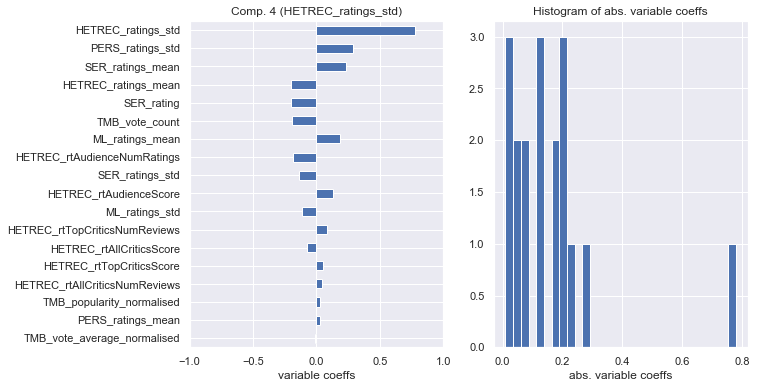

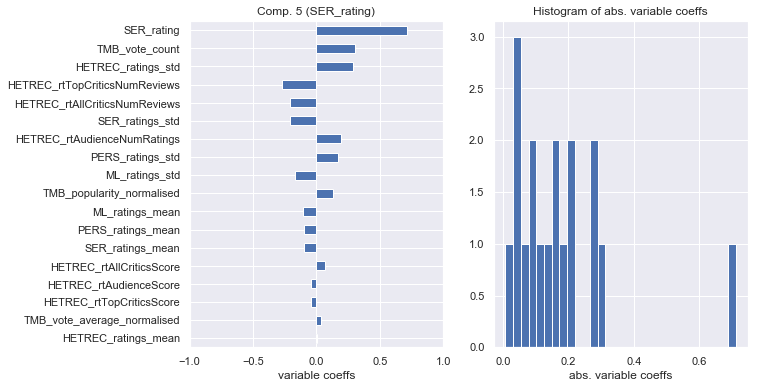

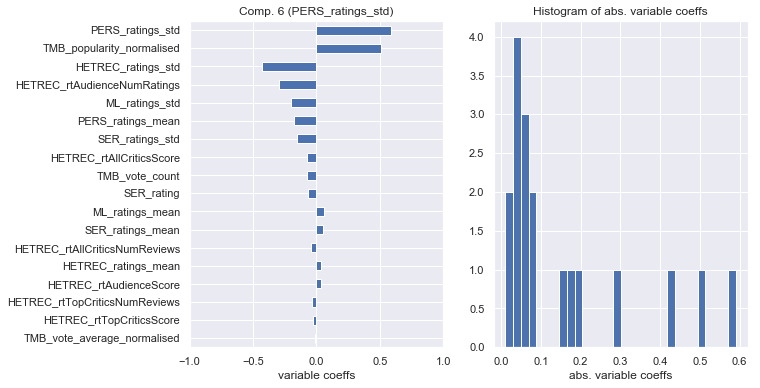

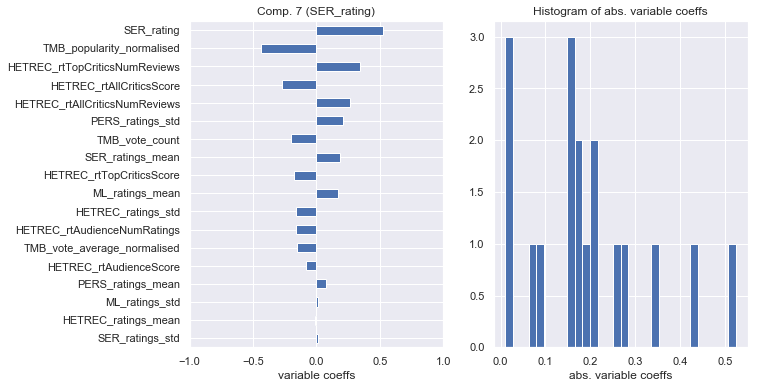

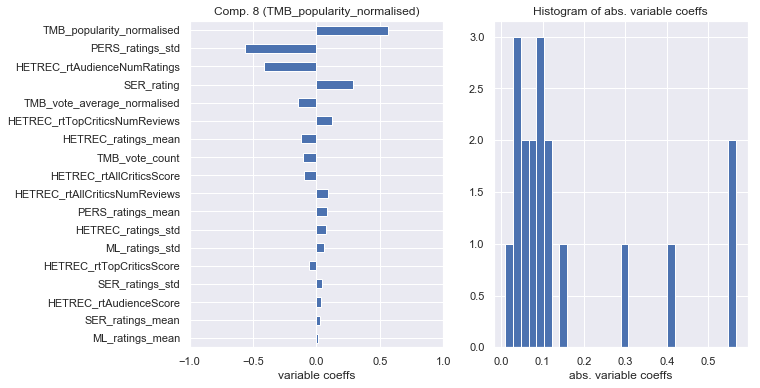

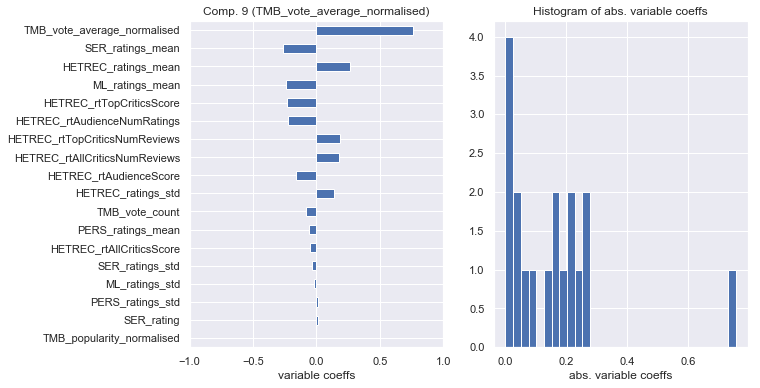

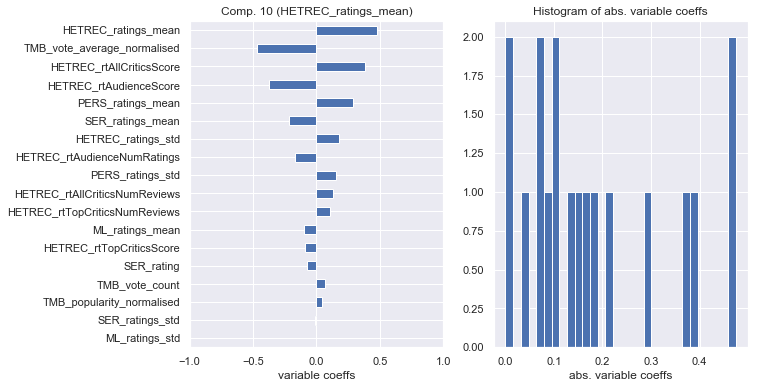

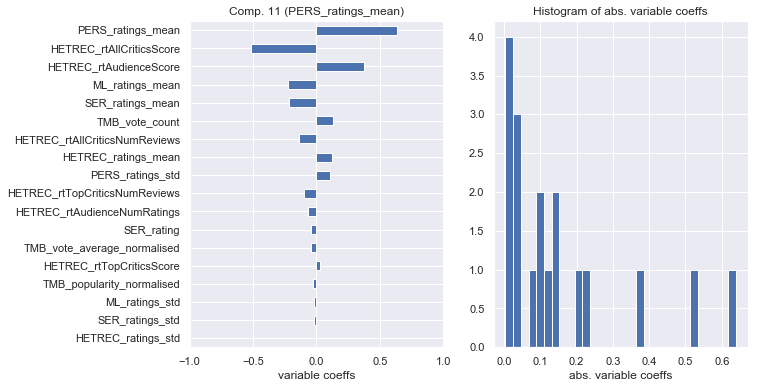

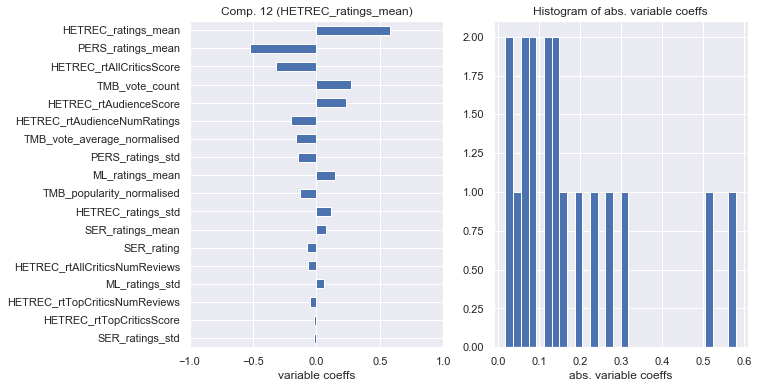

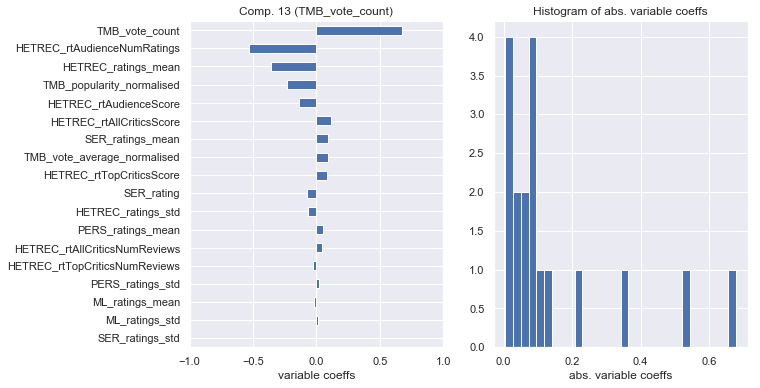

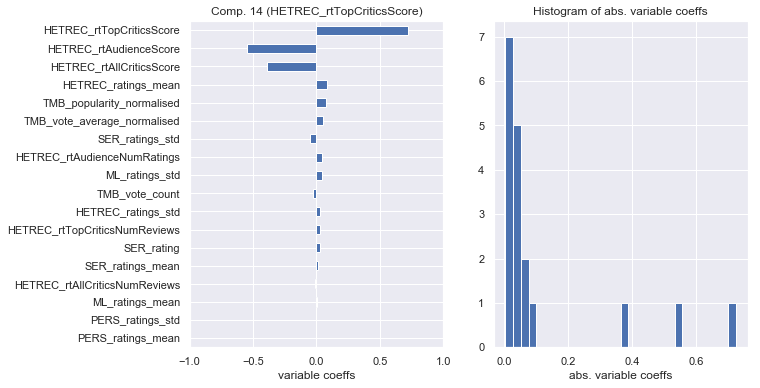

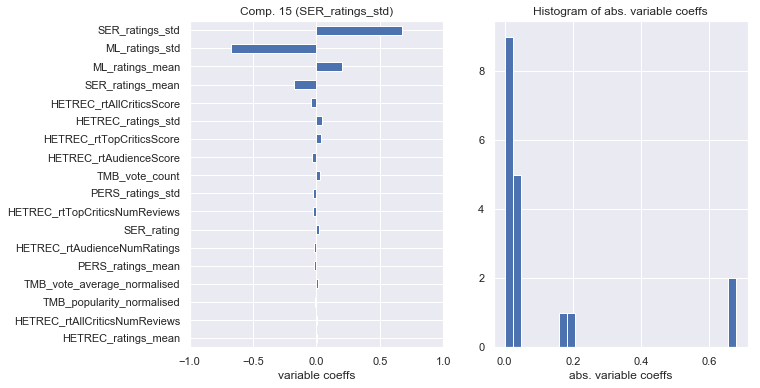

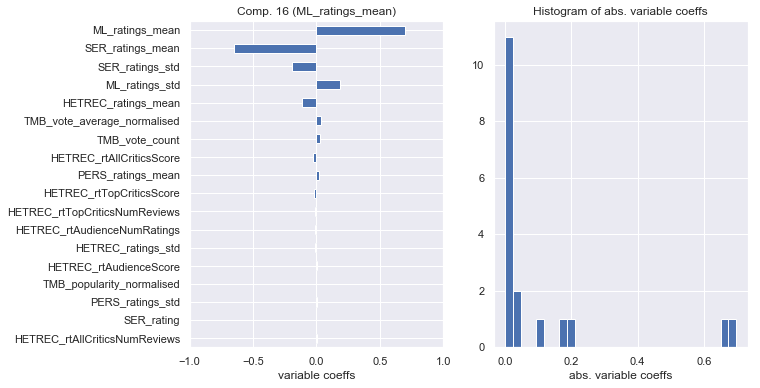

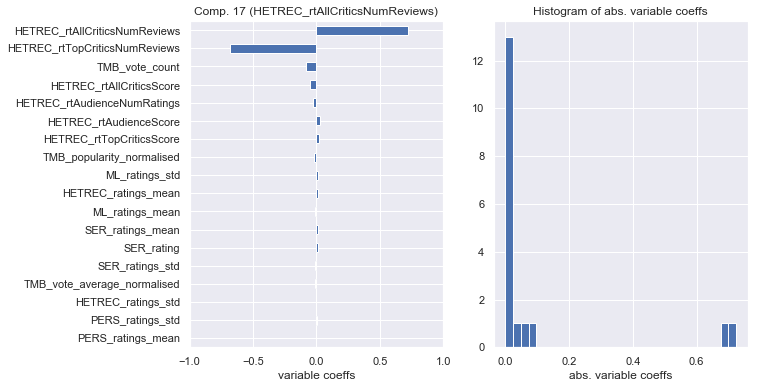

In [82]:
# decomp = EMPCA(n_components=2) # super slow!
decomp = WPCA(n_components=18) #332ms # (n_components=30)
# decomp = PCA() # svd_solver='full' # 2s


decomp_method = str(decomp).split("(")[0]
# decomp_method = "EWPCA" # 21 minutes
if len(weights) ==0 or decomp_method == "PCA":
    kwds = {}
else:
    kwds = {'weights': weights}

X_r = decomp.fit_transform(BES_std, **kwds)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = data.index)


subdir = create_subdir(".."+os.sep+"Output"+os.sep,"ratings_fusion_wpca")

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          data.columns, BES_decomp, manifest=None,
                                                          save_folder = subdir, 
                                                          show_first_x_comps= 20, show_histogram = True)

In [77]:
# decomp = EMPCA(n_components=2) # super slow!
# # decomp = WPCA(n_components=2) #332ms # (n_components=30)
# # decomp = PCA() # svd_solver='full' # 2s


# decomp_method = str(decomp).split("(")[0]
# # decomp_method = "EWPCA" # 21 minutes
# if len(weights) ==0 or decomp_method == "PCA":
#     kwds = {}
# else:
#     kwds = {'weights': weights}

# X_r = decomp.fit_transform(BES_std, **kwds)
# n_components = decomp.components_.shape[0]
# BES_decomp = pd.DataFrame(   X_r,
#                              columns = range(0,n_components),
#                              index   = data.index)


# subdir = create_subdir(".."+os.sep+"Output"+os.sep,"ratings_fusion_wpca")

# (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
#                                                           data.columns, BES_decomp, manifest=None,
#                                                           save_folder = subdir, 
#                                                           show_first_x_comps= 20, show_histogram = True)

Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:54:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.09989
Will train until validation_0-rmse hasn't improved in 10.200000000000001 rounds.
[1]	validation_0-rmse:1.08529
[2]	validation_0-rmse:1.07249
[3]	validation_0-rmse:1.06025
[4]	validation_0-rmse:1.04887
[5]	validation_0-rmse:1.03878
[6]	validation_0-rmse:1.02977
[7]	validation_0-rmse:1.02133
[8]	validation_0-rmse:1.01327
[9]	validation_0-rmse:1.00598
[10]	validation_0-rmse:0.999332
[11]	validation_0-rmse:0.993334
[12]	validation_0-rmse:0.988102
[13]	validation_0-rmse:0.983237
[14]	validation_0-rmse:0.978652
[15]	validation_0-rmse:0.974709
[16]	validation_0-rmse:0.971081
[17]	validation_0-rmse:0.967593
[18]	validation_0-rmse:0.964814
[19]	validation_0-rmse:0.962044
[20]	validation_0-rmse:0.959516
[21]	validation_0-rmse:0.957146
[22]	validation_0-rmse:0.955302
[23]	validation_0-rmse:0.953003
[24]	va

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:55:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


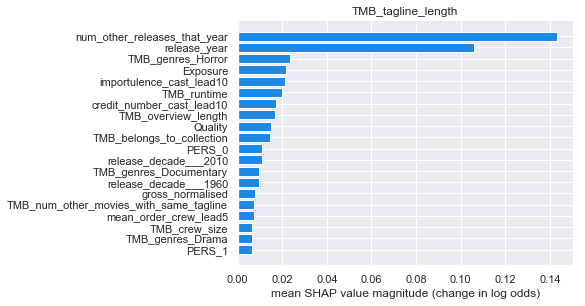

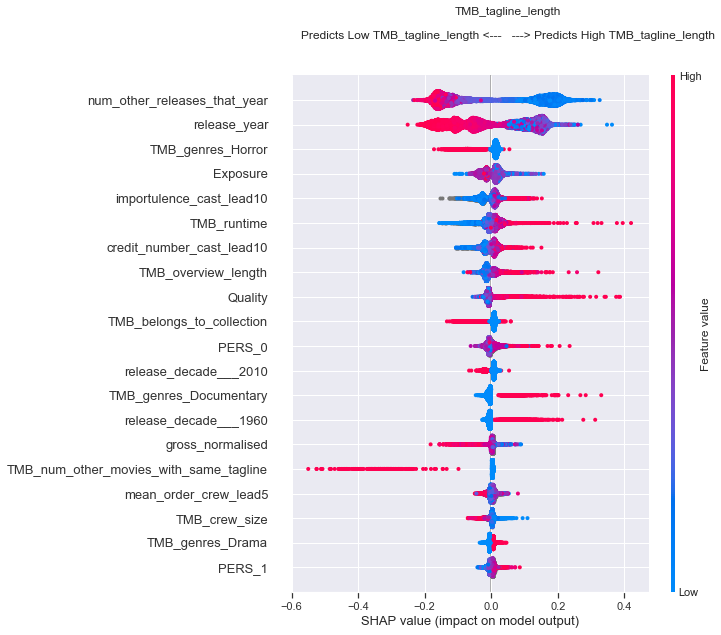

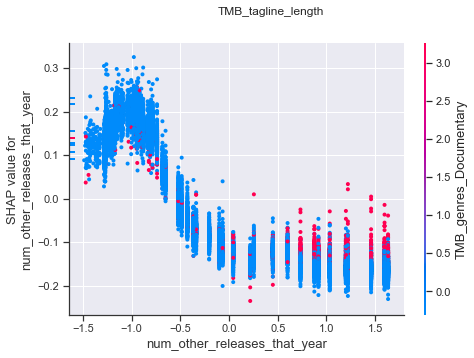

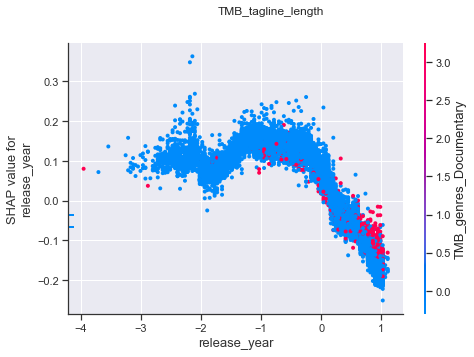

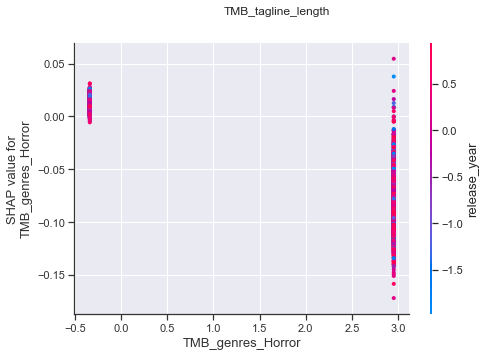

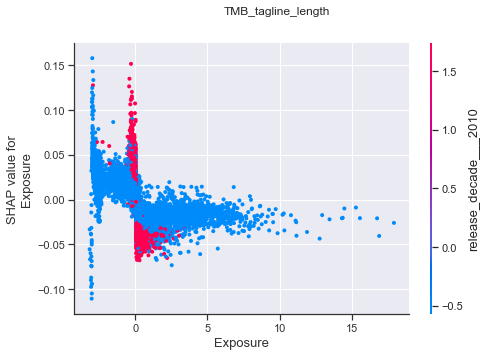

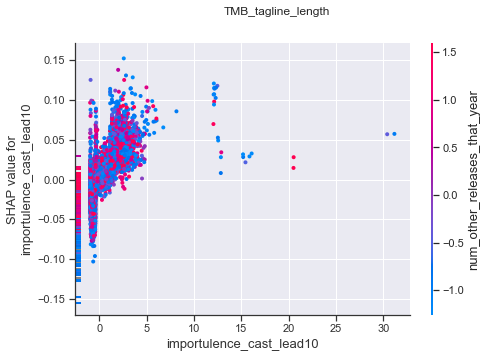

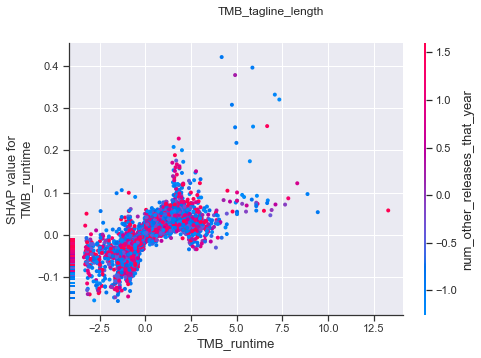

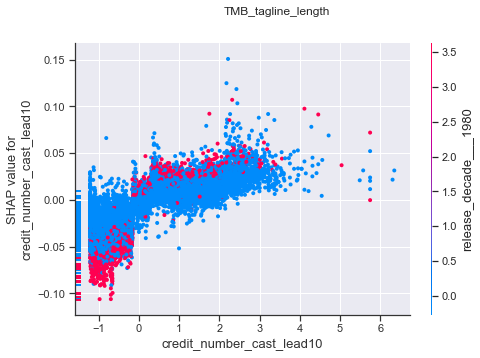

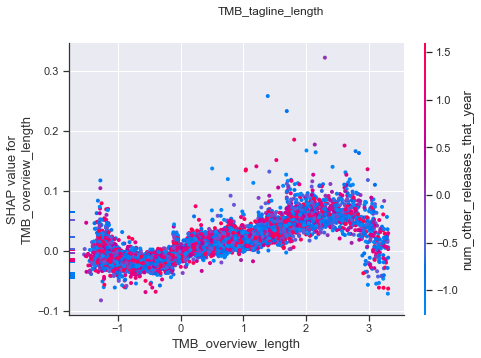

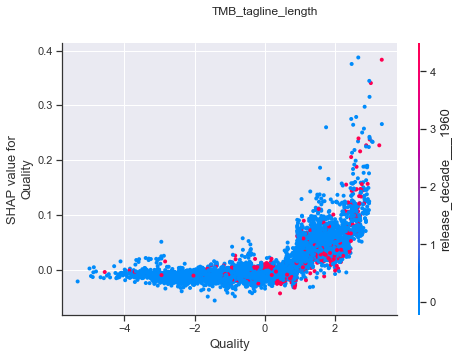

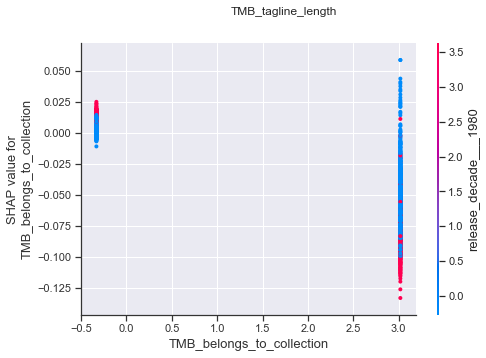

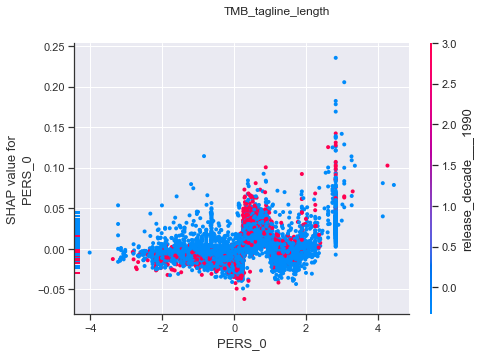

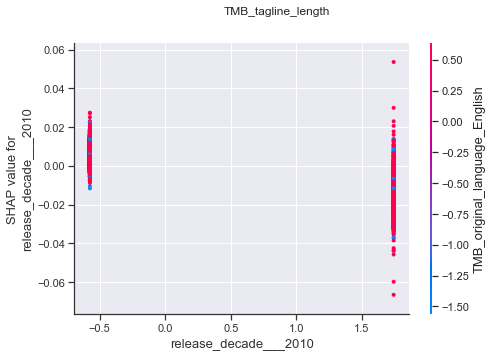

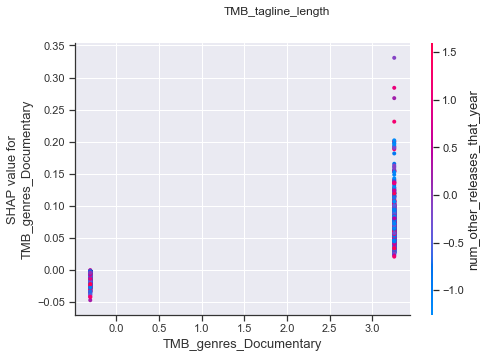

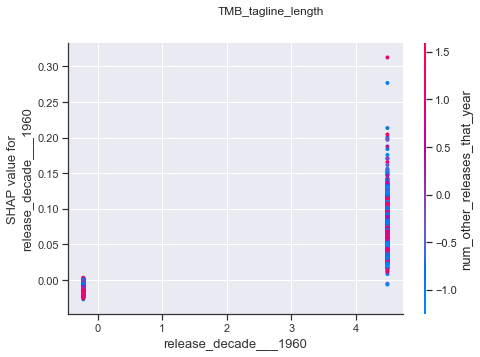

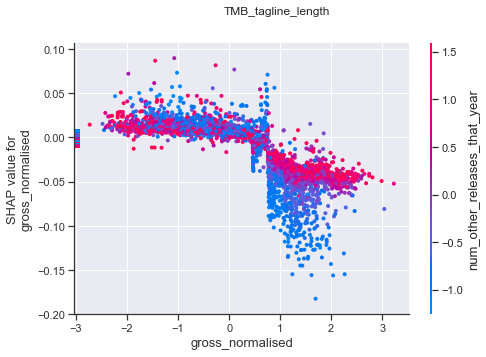

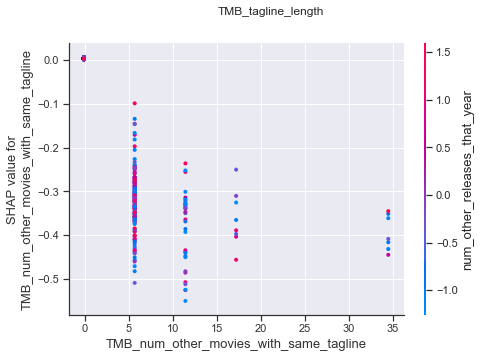

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


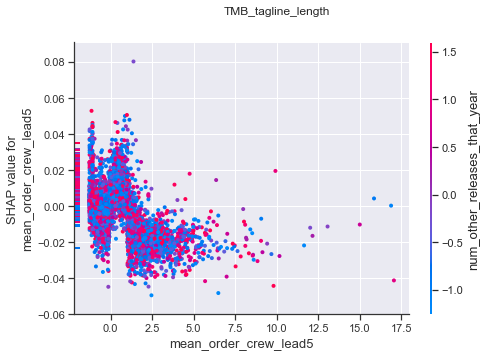

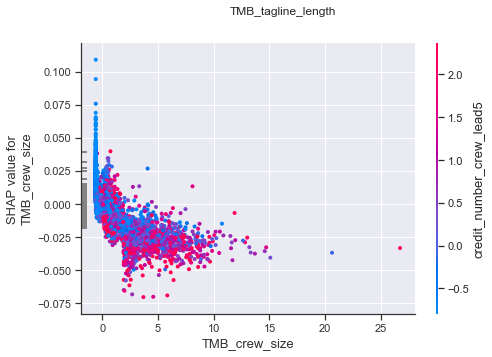

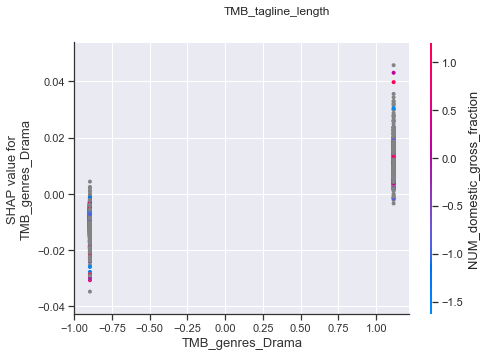

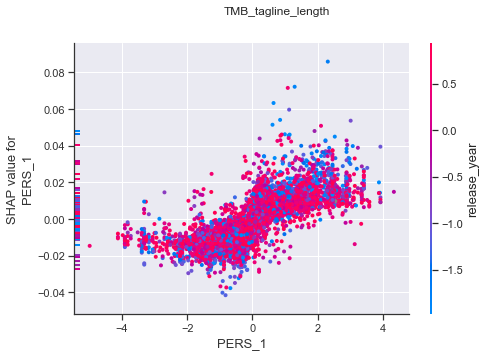

Wall time: 14min 14s


In [319]:
%%time
global BES_output_folder
drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

# drop_cols.extend(fused_cols)

# drop_cols.extend(["release_year","gross_normalised",
#                   "TMB_num_other_movies_with_same_homepage"]) # inflation is cheating!
var_name = "TMB_tagline_length"


BES_output_folder= ".."+os.sep+"Output"+os.sep


df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,20),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True,
                                       output_folder=BES_output_folder,Treatment=Treatment)
